# Prediction of Active Regulatory Regions
## Alice Schiavone

Project for the course *Bioinformatics* at *Università degli Studi di Milano Statale* held by Giorgio Valentini. Code and libraries from the [work](https://github.com/LucaCappelletti94/bioinformatics_practice) of Luca Cappelletti.


Working on the "HG38" dataset and the K562 cell line, we consider the following:
* Task 1: Active Enhancers vs Inactive Enhancers (AE vs IE)
* Task 2: Active Promoters vs Inactive Promoters (AP vs IP)

# Set up

In [ ]:
!pip install epigenomic_dataset ucsc_genomes_downloader keras_bed_sequence umap-learn tsnecuda minepy
!pip install keras_bed_sequence keras_mixed_sequence -U
!pip install keras-tqdm extra_keras_metrics 

In [ ]:
import numpy as np
import pandas as pd
import keras
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Data Retrieval

**Parameters**

In [ ]:
cell_line = "K562"
genome = "hg38"

window_size = 256

enchancer_t = 0.0 # threshold
promoter_t  = 0.0 # threshold

Via the [Epigenomic Dataset](https://github.com/AnacletoLAB/epigenomic_dataset) data wrapper we download the promoters and enhancers data from [FANTOM5](https://fantom.gsc.riken.jp/) with the expression value (TPMs) of each gene.

In [ ]:
from tqdm.auto import tqdm
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters

data = dict()

tasks = [
  ('enhancers', active_enhancers_vs_inactive_enhancers, enchancer_t),
  ('promoters', active_promoters_vs_inactive_promoters, promoter_t)
]

for task, function, threshold in tqdm(tasks, desc="Data Retrieval"):
  X, y = function(
      binarize = False,
      cell_line = cell_line,
      window_size = window_size
  )
  data[task] = {'X':X, 'y':y}
  data[task]['training_history'] = {}
  data[task]['evaluation'] = {}
  data[task]['features_to_remove'] = set()

  print(
      f'Task "{function.__name__}" has:\n'
      f'-  X.shape {X.shape} and y.shape {y.shape}\n'
      f'-  Rate between features and samples: {X.shape[0] / X.shape[1]}\n'
      f'-  Number of NaN values: {X.isna().values.sum()}\n'
      f'   The average of missing values for the samples is {X.isna().sum(axis=1).mean():0.5f}, for the features it is {X.isna().sum(axis=0).mean():0.5f}\n'
  )

Data Retrieval:   0%|          | 0/2 [00:00<?, ?it/s]

Task "active_enhancers_vs_inactive_enhancers" has:
-  X.shape (63285, 429) and y.shape (63285, 1)
-  Rate between features and samples: 147.5174825174825
-  Number of NaN values: 102
   The average of missing values for the samples is 0.00161, for the features it is 0.23776

Task "active_promoters_vs_inactive_promoters" has:
-  X.shape (99881, 429) and y.shape (99881, 1)
-  Rate between features and samples: 232.82284382284382
-  Number of NaN values: 496
   The average of missing values for the samples is 0.00497, for the features it is 1.15618



# Data Exploration and Preprocessing

In [ ]:
for task in data.keys(): 
  print(task)
  display(data[task]['X'].describe())

enhancers


chrom         SMAD5         NCOA2         ZNF23         NR2F6         CEBPZ  \
count  63285.000000  63285.000000  63285.000000  63285.000000  63285.000000   
mean       0.854204      0.743733      0.831215      0.800811      0.864409   
std        0.878816      0.334574      0.532511      0.334844      0.581483   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.460000      0.520000      0.470000      0.590000      0.510000   
50%        0.720000      0.720000      0.740000      0.780000      0.800000   
75%        1.030000      0.930000      1.080000      0.980000      1.140000   
max       35.750000      6.470000     28.540000      7.480000     47.370000   

chrom         SNIP1        ZBTB7A        ZNF133          NRF1          TAF1  \
count  63285.000000  63284.000000  63285.000000  63285.000000  63284.000000   
mean       0.804661      1.245513      0.907048      1.021286      1.101227   
std        0.453880      2.228033      0.464311      4.122830      2.245365   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.490000      0.310000      0.580000      0.450000      0.000000   
50%        0.770000      0.690000      0.850000      0.660000      0.530000   
75%        1.060000      1.350000      1.160000      0.920000      1.280000   
max       21.400000     68.250000      9.480000    242.180000     64.490000   

chrom  ...         SIN3A       SMARCC2         ZFP91          E2F4  \
count  ...  63285.000000  63285.000000  63285.000000  63285.000000   
mean   ...      0.929765      0.976732      0.862212      1.429998   
std    ...      0.825980      0.777798      1.610566      2.560798   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.530000      0.480000      0.510000      0.060000   
50%    ...      0.780000      0.820000      0.760000      0.830000   
75%    ...      1.110000      1.260000      1.050000      1.800000   
max    ...     24.170000     11.920000    141.530000     96.300000   

chrom         NR3C1         SAFB2          E4F1         NCOR1         NCOA1  \
count  63285.000000  63285.000000  63285.000000  63285.000000  63285.000000   
mean       0.810822      0.649336      1.008343      1.075286      0.808300   
std        0.425050      0.509271      1.594609      1.834175      0.520243   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.510000      0.270000      0.470000      0.450000      0.480000   
50%        0.770000      0.550000      0.780000      0.770000      0.770000   
75%        1.060000      0.930000      1.200000      1.200000      1.080000   
max        5.020000      4.700000    175.740000    111.920000     37.360000   

chrom          KLF1  
count  63285.000000  
mean       0.942412  
std        0.563087  
min        0.000000  
25%        0.610000  
50%        0.870000  
75%        1.170000  
max       34.320000  

[8 rows x 429 columns]

promoters


chrom         SMAD5         NCOA2         ZNF23         NR2F6         CEBPZ  \
count  99881.000000  99881.000000  99881.000000  99881.000000  99881.000000   
mean       2.238571      0.657735      0.879565      0.860949      1.241882   
std        2.650387      0.930009      0.589551      0.391718      2.192965   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.620000      0.410000      0.460000      0.620000      0.560000   
50%        1.100000      0.600000      0.790000      0.830000      0.950000   
75%        3.070000      0.800000      1.190000      1.060000      1.450000   
max       55.770000     38.470000     24.840000     16.170000     78.080000   

chrom         SNIP1        ZBTB7A        ZNF133          NRF1          TAF1  \
count  99881.000000  99881.000000  99881.000000  99881.000000  99881.000000   
mean       0.831541      3.811772      1.017048      8.070131      6.555876   
std        1.723633      5.233189      0.522413     23.177855     10.750923   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.390000      0.760000      0.650000      0.570000      0.450000   
50%        0.690000      1.910000      0.960000      1.040000      1.760000   
75%        1.020000      4.810000      1.310000      3.560000      8.560000   
max      148.680000    116.890000      7.420000    428.950000    226.500000   

chrom  ...         SIN3A       SMARCC2         ZFP91          E2F4  \
count  ...  99881.000000  99881.000000  99881.000000  99881.000000   
mean   ...      2.409723      0.981741      1.510206      7.417156   
std    ...      2.873567      0.686464      6.726482     13.299242   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.680000      0.490000      0.520000      0.870000   
50%    ...      1.230000      0.890000      0.860000      2.560000   
75%    ...      3.270000      1.350000      1.260000      9.110000   
max    ...     51.440000     12.940000    353.440000    325.240000   

chrom         NR3C1         SAFB2          E4F1         NCOR1         NCOA1  \
count  99881.000000  99881.000000  99881.000000  99881.000000  99881.000000   
mean       0.797512      0.601236      2.889943      1.165788      0.699335   
std        0.500373      0.441843     16.807033      1.482469      0.462811   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.440000      0.280000      0.490000      0.440000      0.370000   
50%        0.760000      0.530000      1.010000      0.880000      0.650000   
75%        1.090000      0.840000      2.210000      1.510000      0.970000   
max        9.970000      3.860000    914.370000     66.960000     11.170000   

chrom          KLF1  
count  99881.000000  
mean       1.298927  
std        1.111308  
min        0.000000  
25%        0.660000  
50%        1.040000  
75%        1.620000  
max       46.240000  

[8 rows x 429 columns]

Value distribution

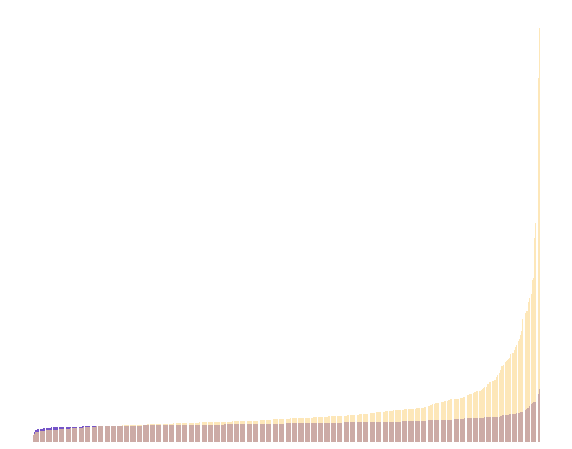

In [ ]:
colors = ['#7554c8','#fcdb94']
plt.figure(figsize=(10,8))

for j, task, color in zip([1,0.65], data.keys(), colors):
  mean_features = sorted(np.mean(data[task]['X'], axis=0))
  plt.bar([x for x in range(len(mean_features))], mean_features,
          alpha=j, color=color)
plt.axis("off")
plt.show()

### Imputation and costant values

Fill NaN values (data imputation) with K-Nearest Neighbors with a euclidean distance from sklearn KNNImputer.

In [ ]:
from sklearn.impute import KNNImputer

def knn_imputation(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

for task in data.keys():
  data[task]['X'] = knn_imputation(data[task]['X'])
  print('After imputing:')
  print(f"- NaN values for {task}: {data[task]['X'].isna().values.sum()}")

After imputing:
- NaN values for enhancers: 0
After imputing:
- NaN values for promoters: 0


Drop features with constant values which do not add any information. In our case, no feature is dropped.

In [ ]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    print(f"Before drop shape: ", df.shape)
    df = df.loc[:, (df != df.iloc[0]).any()]
    print(f"After drop shape: ", df.shape)
    return df

for task in data.keys():
  data[task]['X'] = drop_constant_features(data[task]['X'])

Before drop shape:  (63285, 429)
After drop shape:  (63285, 429)
Before drop shape:  (99881, 429)
After drop shape:  (99881, 429)


### Robust z-scoring

In order to scale values in a robust fashion, we substruct the median and divide by the standard deviation $\sigma$ between the interquantile range $IQR=Q_3-Q_1$. A convenient sklearn function can be used for it.

In [ ]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

for task in data.keys():
  data[task]['X'] = robust_zscoring(data[task]['X'])

In [ ]:
for task in data.keys(): 
  print(task)
  display(data[task]['X'].describe())

enhancers


chrom         SMAD5         NCOA2         ZNF23         NR2F6         CEBPZ  \
count  63285.000000  63285.000000  63285.000000  63285.000000  63285.000000   
mean       0.235445      0.057884      0.149533      0.053362      0.102236   
std        1.541783      0.816035      0.872969      0.858575      0.922989   
min       -1.263158     -1.756098     -1.213115     -2.000000     -1.269841   
25%       -0.456140     -0.487805     -0.442623     -0.487179     -0.460317   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.543860      0.512195      0.557377      0.512821      0.539683   
max       61.456140     14.024390     45.573770     17.179487     73.920635   

chrom         SNIP1        ZBTB7A        ZNF133          NRF1          TAF1  \
count  63285.000000  63285.000000  63285.000000  63285.000000  63285.000000   
mean       0.060809      0.534129      0.098359      0.768693      0.446258   
std        0.796281      2.142327      0.800536      8.771979      1.754181   
min       -1.350877     -0.663462     -1.465517     -1.404255     -0.414062   
25%       -0.491228     -0.365385     -0.465517     -0.446809     -0.414062   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.508772      0.634615      0.534483      0.553191      0.585938   
max       36.192982     64.961538     14.879310    513.872340     49.968750   

chrom  ...         SIN3A       SMARCC2         ZFP91          E2F4  \
count  ...  63285.000000  63285.000000  63285.000000  63285.000000   
mean   ...      0.258215      0.200939      0.189282      0.344826   
std    ...      1.424104      0.997177      2.982530      1.471723   
min    ...     -1.344828     -1.051282     -1.407407     -0.477011   
25%    ...     -0.431034     -0.435897     -0.462963     -0.442529   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.568966      0.564103      0.537037      0.557471   
max    ...     40.327586     14.230769    260.685185     54.867816   

chrom         NR3C1         SAFB2          E4F1         NCOR1         NCOA1  \
count  63285.000000  63285.000000  63285.000000  63285.000000  63285.000000   
mean       0.074222      0.150509      0.312798      0.407047      0.063833   
std        0.772818      0.771623      2.184396      2.445567      0.867071   
min       -1.400000     -0.833333     -1.068493     -1.026667     -1.283333   
25%       -0.472727     -0.424242     -0.424658     -0.426667     -0.483333   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.527273      0.575758      0.575342      0.573333      0.516667   
max        7.727273      6.287879    239.671233    148.200000     60.983333   

chrom          KLF1  
count  63285.000000  
mean       0.129307  
std        1.005512  
min       -1.553571  
25%       -0.464286  
50%        0.000000  
75%        0.535714  
max       59.732143  

[8 rows x 429 columns]

promoters


chrom         SMAD5         NCOA2         ZNF23         NR2F6         CEBPZ  \
count  99881.000000  99881.000000  99881.000000  99881.000000  99881.000000   
mean       0.464723      0.148039      0.122691      0.070339      0.327957   
std        1.081791      2.384639      0.807604      0.890268      2.464006   
min       -0.448980     -1.538462     -1.082192     -1.886364     -1.067416   
25%       -0.195918     -0.487179     -0.452055     -0.477273     -0.438202   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.804082      0.512821      0.547945      0.522727      0.561798   
max       22.314286     97.102564     32.945205     34.863636     86.662921   

chrom         SNIP1        ZBTB7A        ZNF133          NRF1          TAF1  \
count  99881.000000  99881.000000  99881.000000  99881.000000  99881.000000   
mean       0.224668      0.469573      0.086437      2.351214      0.591353   
std        2.735925      1.292145      0.791534      7.751791      1.325638   
min       -1.095238     -0.471605     -1.454545     -0.347826     -0.217016   
25%       -0.476190     -0.283951     -0.469697     -0.157191     -0.161529   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.523810      0.716049      0.530303      0.842809      0.838471   
max      234.904762     28.390123      9.787879    143.113712     27.711467   

chrom  ...         SIN3A       SMARCC2         ZFP91          E2F4  \
count  ...  99881.000000  99881.000000  99881.000000  99881.000000   
mean   ...      0.455491      0.106675      0.878657      0.589461   
std    ...      1.109485      0.798214      9.089841      1.613986   
min    ...     -0.474903     -1.034884     -1.162162     -0.310680   
25%    ...     -0.212355     -0.465116     -0.459459     -0.205097   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.787645      0.534884      0.540541      0.794903   
max    ...     19.386100     14.011628    476.459459     39.160194   

chrom         NR3C1         SAFB2          E4F1         NCOR1         NCOA1  \
count  99881.000000  99881.000000  99881.000000  99881.000000  99881.000000   
mean       0.057710      0.127207      1.092990      0.267092      0.082225   
std        0.769805      0.789006      9.771531      1.385485      0.771351   
min       -1.169231     -0.946429     -0.587209     -0.822430     -1.083333   
25%       -0.492308     -0.446429     -0.302326     -0.411215     -0.466667   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.507692      0.553571      0.697674      0.588785      0.533333   
max       14.169231      5.946429    531.023256     61.757009     17.533333   

chrom          KLF1  
count  99881.000000  
mean       0.269716  
std        1.157613  
min       -1.083333  
25%       -0.395833  
50%        0.000000  
75%        0.604167  
max       47.083333  

[8 rows x 429 columns]

### Label binarization
based on selected thresholds

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def binarize(y:pd.DataFrame, clip_value:float)->pd.DataFrame:
  labels = data[task]['y'].values
  labels = MinMaxScaler(feature_range=(0, 1)).fit_transform(labels)
  labels = np.where(labels > clip_value, 1, 0)
  return pd.DataFrame(labels, index=data[task]['y'].index, columns=['K562']).astype(float)

for task, clip_value in zip(data.keys(), [enchancer_t, promoter_t]): data[task]['binary_y'] = binarize(data[task]['y'], clip_value)

for task in data.keys():
  value_count = np.unique(data[task]['binary_y'], return_counts=True)[1]
  print(f'For {task}:\n'
        f'-  Distribution of the labels (F/T): {value_count}\n'
        f'   So a ratio of {value_count[1]/value_count[0]:0.3f} Positives to Negatives with threshold {threshold}'
  )

For enhancers:
-  Distribution of the labels (F/T): [57761  5524]
   So a ratio of 0.096 Positives to Negatives with threshold 0.0
For promoters:
-  Distribution of the labels (F/T): [66346 33535]
   So a ratio of 0.505 Positives to Negatives with threshold 0.0


# Feature selection

### Correlation with the output

To reduce dimensionality and have a faster training, we want to drop features that are not correlated to the output, neither positive nor negative. 

Because not all relations are linear or monotonic, we first start by dropping features not relevant to the task with respect to the Pearson's and Spearman's coefficients, but then we compute non-linear scores.

In [ ]:
p_value_threshold = 0.01
correlation_threshold = 0.05

In [ ]:
from scipy.stats import pearsonr

for task in data.keys():
  X = data[task]['X']
  y = data[task]['y']
  print(f"\nTask: ", task)
  for feature in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
      correlation, p_value = pearsonr(X[feature].values.flatten(), y.values.flatten())
      if p_value > p_value_threshold:
          print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")
          data[task]['features_to_remove'].add(feature)


Task:  enhancers


Running Pearson test:   0%|                                                                    | 0/429 [00:00<…

The feature STAG1 does not correlate in a statistically significant manner with the output.
The feature XRCC3 does not correlate in a statistically significant manner with the output.
The feature ILK does not correlate in a statistically significant manner with the output.
The feature ZNF830 does not correlate in a statistically significant manner with the output.
The feature HNRNPH1 does not correlate in a statistically significant manner with the output.
The feature RBM17 does not correlate in a statistically significant manner with the output.
The feature NR0B1 does not correlate in a statistically significant manner with the output.
The feature whole-genome shotgun bisulfite sequencing does not correlate in a statistically significant manner with the output.
The feature ZNF778 does not correlate in a statistically significant manner with the output.
The feature H4K20me1 does not correlate in a statistically significant manner with the output.
The feature SNRNP70 does not correlate 

Running Pearson test:   0%|                                                                    | 0/429 [00:00<…

The feature ZKSCAN3 does not correlate in a statistically significant manner with the output.
The feature ZNF785 does not correlate in a statistically significant manner with the output.
The feature U2AF2 does not correlate in a statistically significant manner with the output.
The feature RBM17 does not correlate in a statistically significant manner with the output.
The feature ARID2 does not correlate in a statistically significant manner with the output.
The feature ZBTB33 does not correlate in a statistically significant manner with the output.
The feature ZNF408 does not correlate in a statistically significant manner with the output.
The feature RFX1 does not correlate in a statistically significant manner with the output.
The feature EHMT2 does not correlate in a statistically significant manner with the output.
The feature ZBTB8A does not correlate in a statistically significant manner with the output.
The feature MIER1 does not correlate in a statistically significant manner 

In [ ]:
from scipy.stats import spearmanr

for task in data.keys():
  X = data[task]['X']
  y = data[task]['y']
  print(f"\nTask: ", task)
  for feature in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
      correlation, p_value = spearmanr(X[feature].values.flatten(), y.values.flatten())
      if p_value > p_value_threshold:
          print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")
          data[task]['features_to_remove'].add(feature)


Task:  enhancers


Running Spearman test:   0%|                                                                   | 0/429 [00:00<…

The feature SUZ12 does not correlate in a statistically significant manner with the output.
The feature U2AF2 does not correlate in a statistically significant manner with the output.
The feature RBM17 does not correlate in a statistically significant manner with the output.
The feature FOXJ3 does not correlate in a statistically significant manner with the output.
The feature SRSF7 does not correlate in a statistically significant manner with the output.
The feature DLX4 does not correlate in a statistically significant manner with the output.
The feature EWSR1 does not correlate in a statistically significant manner with the output.
The feature TSC22D4 does not correlate in a statistically significant manner with the output.
The feature MCM7 does not correlate in a statistically significant manner with the output.

Task:  promoters


Running Spearman test:   0%|                                                                   | 0/429 [00:00<…

The feature ZNF785 does not correlate in a statistically significant manner with the output.
The feature ARHGAP35 does not correlate in a statistically significant manner with the output.


In [ ]:
for task in data.keys(): print(task, data[task]['features_to_remove'])

enhancers {'MCM2', 'U2AF2', 'RFX1', 'whole-genome shotgun bisulfite sequencing', 'ZNF318', 'YBX1', 'FOXJ3', 'ZNF830', 'RBM17', 'TSC22D4', 'STAG1', 'SAFB2', 'CEBPG', 'ZNF778', 'SRSF7', 'RBM15', 'XRCC3', 'ILK', 'DLX4', 'PCBP2', 'ZNF280A', 'ZBTB8A', 'SNRNP70', 'ATF2', 'H4K20me1', 'HNRNPH1', 'FOXA1', 'SUZ12', 'MCM7', 'NR0B1', 'EWSR1'}
promoters {'U2AF2', 'ZNF785', 'PTRF', 'RFX1', 'ARID2', 'MIER1', 'RBM17', 'KLF10', 'NCOA1', 'SMARCA5', 'EHMT2', 'ZKSCAN3', 'ZNF408', 'ZNF319', 'ZNF512', 'ZBTB8A', 'ARHGAP35', 'ZBTB33', 'NCOA4'}


Compute Non-Linear Correlations for the features that do not appear correlated with the output with Pearson's and Spearman's, but could have relationships which are not linear or monotonic. We remove them from the 'features_to_remove' set if that's the case, but because we expect MINE to also notice linear and monotonic relatioships, we are glad to see that no features is removed.

In [ ]:
from minepy import MINE

def compute_MINE():
  for task in data.keys():
    X = data[task]['X']
    y = data[task]['y']
    print(f"\nTask: ", task)
    for feature in tqdm(data[task]['features_to_remove'], desc=f"Running MINE test", dynamic_ncols=True, leave=False):
        mine = MINE()
        mine.compute_score(X[feature].values.ravel(), y.values.ravel())
        score = mine.mic()
        if score < correlation_threshold:
            print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")
            data[task]['features_to_remove'].add(feature)
        else:
            print(f"*** The feature {feature} does correlate in a statistically significant manner with the output.")
            data[task]['features_to_remove'].minus(feature)

compute_MINE()


Task:  enhancers


Running MINE test:   0%|                                                                        | 0/31 [00:00<…

The feature MCM2 does not correlate in a statistically significant manner with the output.
The feature U2AF2 does not correlate in a statistically significant manner with the output.
The feature RFX1 does not correlate in a statistically significant manner with the output.
The feature whole-genome shotgun bisulfite sequencing does not correlate in a statistically significant manner with the output.
The feature ZNF318 does not correlate in a statistically significant manner with the output.
The feature YBX1 does not correlate in a statistically significant manner with the output.
The feature FOXJ3 does not correlate in a statistically significant manner with the output.
The feature ZNF830 does not correlate in a statistically significant manner with the output.
The feature RBM17 does not correlate in a statistically significant manner with the output.
The feature TSC22D4 does not correlate in a statistically significant manner with the output.
The feature STAG1 does not correlate in a s

Running MINE test:   0%|                                                                        | 0/19 [00:00<…

The feature U2AF2 does not correlate in a statistically significant manner with the output.
The feature ZNF785 does not correlate in a statistically significant manner with the output.
The feature PTRF does not correlate in a statistically significant manner with the output.
The feature RFX1 does not correlate in a statistically significant manner with the output.
The feature ARID2 does not correlate in a statistically significant manner with the output.
The feature MIER1 does not correlate in a statistically significant manner with the output.
The feature RBM17 does not correlate in a statistically significant manner with the output.
The feature KLF10 does not correlate in a statistically significant manner with the output.
The feature NCOA1 does not correlate in a statistically significant manner with the output.
The feature SMARCA5 does not correlate in a statistically significant manner with the output.
The feature EHMT2 does not correlate in a statistically significant manner with

Now compute correlations between features, which we want to be low because it would mean we have no repetition in the information. We can do it only for the features which were not removed to save a bit of time. 

> For this particular cell line no correlation between features has been found in previous runs of the code, so we won't run this test to save some time.

In [ ]:
for task in data.keys():
  before_shape = data[task]['X'].shape
  print(data[task]['features_to_remove'])
  data[task]['X'] = data[task]['X'].drop(labels=list(data[task]['features_to_remove']), axis=1)
  data[task]['features_to_remove'] = set()

{'MCM2', 'U2AF2', 'RFX1', 'whole-genome shotgun bisulfite sequencing', 'ZNF318', 'YBX1', 'FOXJ3', 'ZNF830', 'RBM17', 'TSC22D4', 'STAG1', 'SAFB2', 'CEBPG', 'ZNF778', 'SRSF7', 'RBM15', 'XRCC3', 'ILK', 'DLX4', 'PCBP2', 'ZNF280A', 'ZBTB8A', 'SNRNP70', 'ATF2', 'H4K20me1', 'HNRNPH1', 'FOXA1', 'SUZ12', 'MCM7', 'NR0B1', 'EWSR1'}
{'U2AF2', 'ZNF785', 'PTRF', 'RFX1', 'ARID2', 'MIER1', 'RBM17', 'KLF10', 'NCOA1', 'SMARCA5', 'EHMT2', 'ZKSCAN3', 'ZNF408', 'ZNF319', 'ZNF512', 'ZBTB8A', 'ARHGAP35', 'ZBTB33', 'NCOA4'}


In [ ]:
from cache_decorator import Cache

@Cache(
    cache_path="correlations/features/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_correlation(
    f:function,
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str
) -> dict:
    """Returns correlation based on some function.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    f:function,
        The linear correlation function to compute.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    """
    correlation, p_value = f(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

p_value_threshold_btw_features = 0.01 # we would drop these features if the correlation was high
correlation_threshold = 0.99

def correlation_btw_features():
  for task in data.keys():
    X = data[task]['X']
    y = data[task]['y']
    print(f"\nTask: ", task)
    for feature_left in tqdm(X.columns, desc=f"Running Pearson and Spearman test", dynamic_ncols=True, leave=False):
        for feature_right in X.columns:
            if feature_left >= feature_right:
                # Since the pearson (but not spearman) correlation is symmetric, we do not need to check
                # for the entire squared matrix of features but the upper triangular one
                # is sufficient.
                continue
            pearson_result = compute_correlation(pearsonr, X, feature_left, feature_right)
            if pearson_result["p_value"] < p_value_threshold_btw_features and np.abs(pearson_result["correlation"]) > correlation_threshold:
                correlation = pearson_result["correlation"]
                print(f"Pearson --- The feature {feature_left} is highly correlated with {feature_right} ({correlation:.3f}).")
                data[task]['features_to_remove'].add(feature_left)

        for feature_right in X.columns:
            if feature_left == feature_right:
              continue # of course the same feature is correlated to itself
            spearman_result = compute_correlation(spearmanr, X, feature_left, feature_right)
            if spearman_result["p_value"] < p_value_threshold_btw_features and np.abs(spearman_result["correlation"]) > correlation_threshold:
                correlation = spearman_result["correlation"]
                print(f"Spearman --- The feature {feature_left} is highly correlated with {feature_right} ({correlation:.3f}).")
                data[task]['features_to_remove'].add(feature_left)

#correlation_btw_features()

In [ ]:
for task in data.keys():
  print(f"{task} shape before: {before_shape}")
  data[task]['X'] = data[task]['X'].drop(labels=list(data[task]['features_to_remove']), axis=1)
  print(f"{task} shape after: {data[task]['X'].shape}")

enhancers shape before: (99881, 429)
enhancers shape after: (63285, 398)
promoters shape before: (99881, 429)
promoters shape after: (99881, 410)


### Feature selection with Random Forests

Use a Random Forest Classifier to extract the most important features. We run the model multiple times to have significant results. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_runs = 3

for task in data.keys():
  data[task]['feature_selection'] = {}
  X, y = data[task]['X'], np.ravel(data[task]['binary_y'])

  for i in tqdm(range(n_runs), desc = f"Feature selection - {task}"):
    model = RandomForestClassifier(
        criterion='gini',
        n_jobs=-1, # use all processors
        random_state=42,
        warm_start=False
    )
    model.fit(X, y)
    importance = model.feature_importances_
    data[task]['feature_selection'][i] = importance

Feature selection - enhancers:   0%|          | 0/3 [00:00<?, ?it/s]

Feature selection - promoters:   0%|          | 0/3 [00:00<?, ?it/s]

Compute :
* the mean importance between the n-runs per task
* the median importance of features per task (to be robust to outliers)

and plot with a log-scaled y-axis the n-runs with a line to represent the median. Keep only the features with importance above the line.

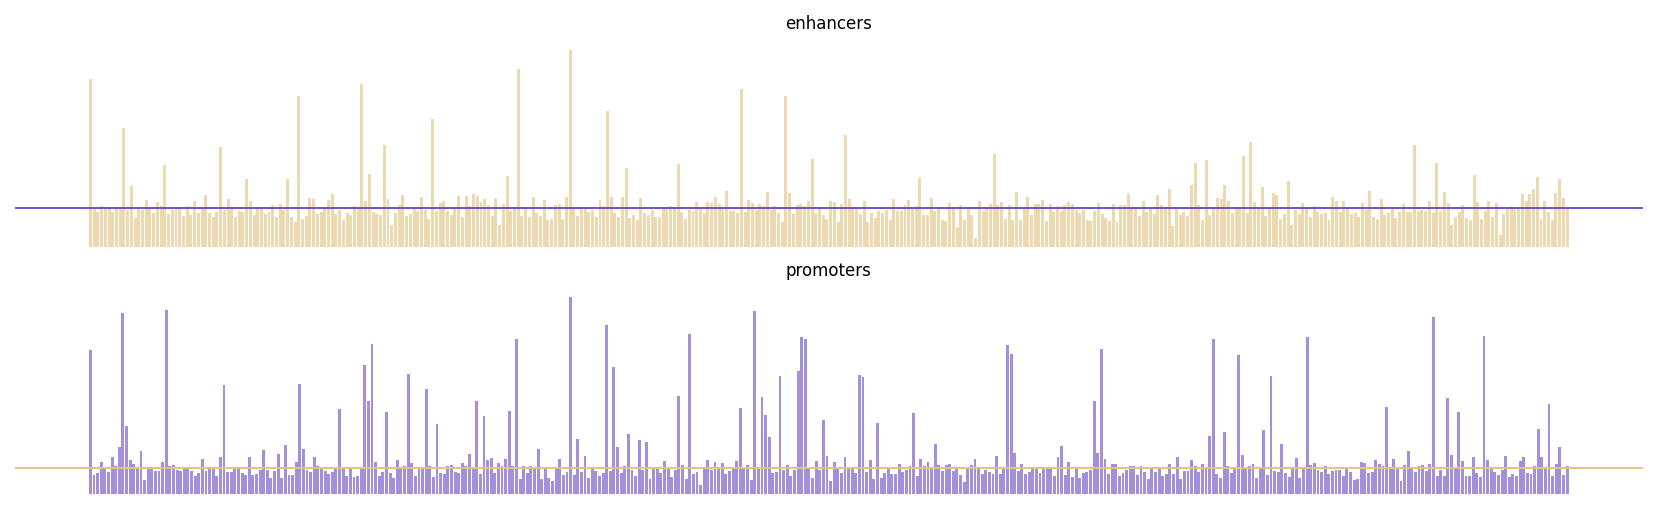

In [ ]:
fig, axs = plt.subplots(2, 1,figsize=(14, 4), dpi=150)
colors = ['#e2c585', '#7554c8']

for j, task, color in zip([0,1], data.keys(), colors):
  data[task]['mean_feature_importance'] = np.mean([data[task]['feature_selection'][i] for i in range(n_runs)], axis=0)
  data[task]['median_importance'] = np.median(data[task]['mean_feature_importance'])

  for i in range(n_runs):
    importance = data[task]['feature_selection'][i]
    axs[j].set_yscale('log')
    axs[j].bar([x for x in range(len(importance))], importance,
            alpha=0.3, color=color)
    axs[j].set_title(task, fontdict = {'fontsize':8})
    axs[j].axis("off")
    axs[j].axhline(y=data[task]['median_importance'], color=colors[(j+1)%2], linestyle='-', linewidth=0.8)
plt.show()

In [ ]:
for i, task in enumerate(data.keys()):
  n_features_before = data[task]['X'].shape[1]
  a = data[task]['mean_feature_importance']
  v = data[task]['median_importance']
  mask = list(np.where(a >= v))
  mask = [data[task]['X'].columns[m] for m in mask][0]
  data[task]['X'] = data[task]['X'][mask]
  n_features_after = data[task]['X'].shape[1]
  print(
      f"{task}\n"
      f"- before #features: {n_features_before}\n"
      f"- after #features: {n_features_after}\n"
      f"- Ratio (features kept): {n_features_after/n_features_before:.2f}"
  )

enhancers
- before #features: 398
- after #features: 199
- Ratio (features kept): 0.50
promoters
- before #features: 410
- after #features: 205
- Ratio (features kept): 0.50


### Retrieving and bedding genomic sequences

After reducing the dimensionality of the feature space we can finally download the human genome for *hg38* and bed it with respect to the epigenomic data.

In [ ]:
from ucsc_genomes_downloader import Genome
genome_sequence = Genome(genome)
genome_sequence

Loading chromosomes for genome hg38:   0%|                                                      | 0/25 [00:00<…

C:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


Human, Homo sapiens, hg38, 2013-12-11, 25 chromosomes

In [ ]:
from keras_bed_sequence import BedSequence

def one_hot_bed_file(y:pd.DataFrame)->pd.DataFrame:
    """Return one-hot encoded bed coordinates from given dataset."""
    y = y.reset_index()[y.index.names] # get the bed indeces from labels (or epigenomic data)
    return np.array(BedSequence(
      genome_sequence, # from ucsc_genomes
      bed=y,
      batch_size=1
    ))

for task in data.keys(): data[task]['genome'] = one_hot_bed_file(data[task]['y'])  

In [ ]:
data['enhancers']['genome']

array([[[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.]]],


       [[[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]],


       [[[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.]]],


       [[[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.]]],


       [[[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
     

In [ ]:
data['enhancers']['genome'].shape

(63285, 1, 256, 4)

# Dimensionality reduction via T-SNE and UMAP

In [ ]:
import umap 

def get_umap_decomposition(
    X: np.array,
)->pd.DataFrame:
    """Return the UMAP decomposition of the given data."""
    return pd.DataFrame(
        umap.UMAP(n_neighbors=10,
                  min_dist=0.3,
                  n_components = 2,
                  metric='cosine').fit_transform(X)
    )

for task in tqdm(data.keys(), desc='UMAP decomposition'):
  data[task]['decomposition'] = get_umap_decomposition(data[task]['X'].values)
  data[task]['genomic_decomposition'] = get_umap_decomposition(data[task]['genome'].reshape(-1, 4*window_size))

UMAP decomposition:   0%|          | 0/2 [00:00<?, ?it/s]

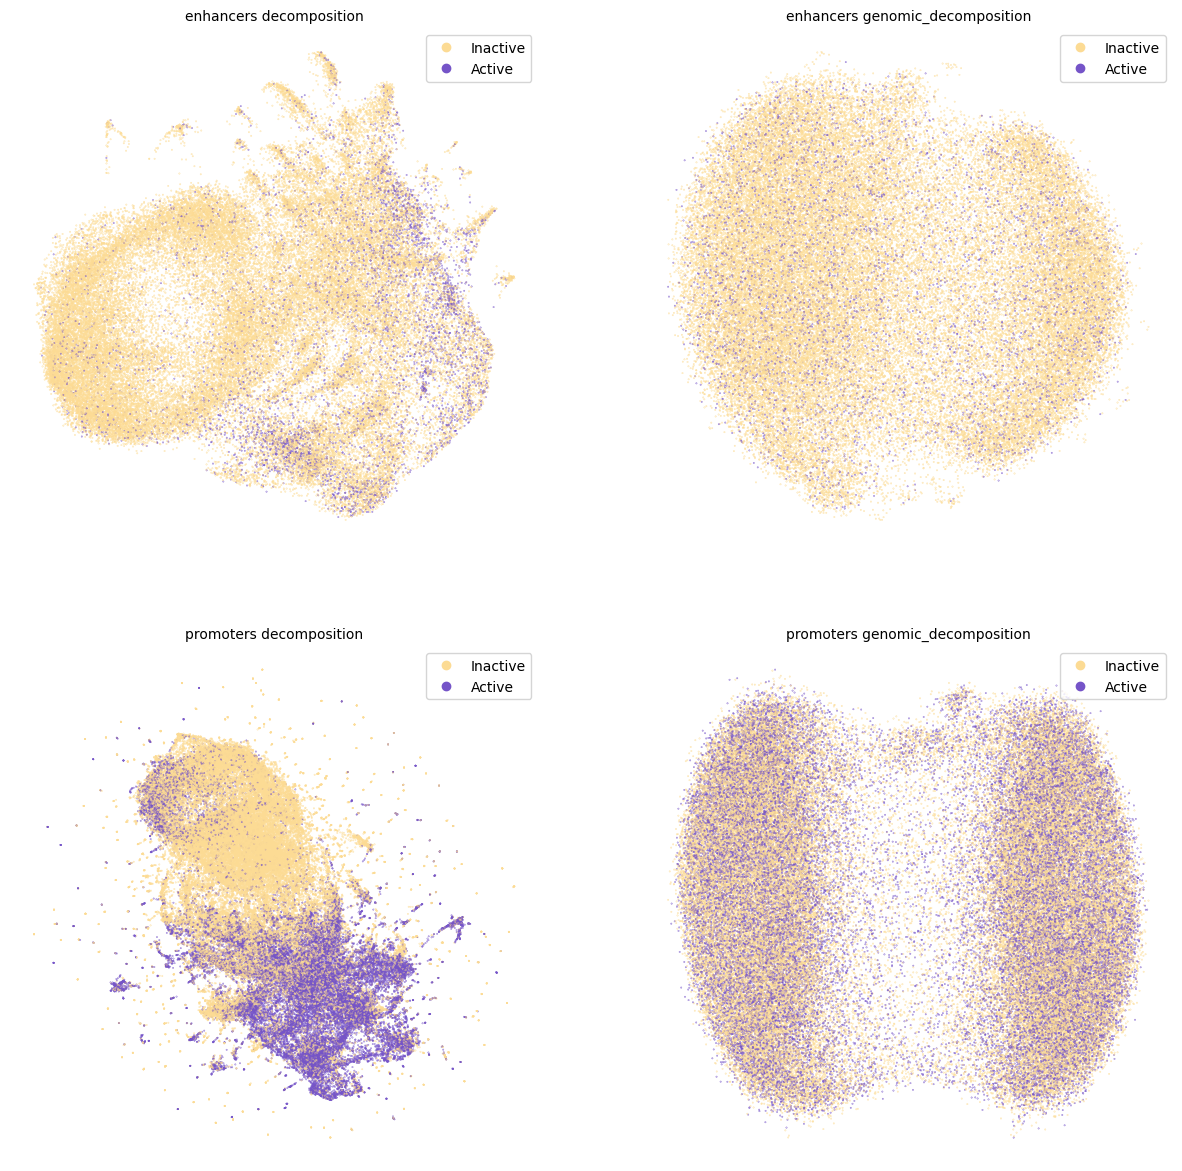

In [ ]:
from matplotlib.pyplot import figure
import matplotlib as mpl

fig, axs = plt.subplots(2, 2,figsize=(15, 15), dpi=100)
for i, task, clip_value in zip([0,1], data.keys(), [0.0, 0.0]):
  for j, data_dec in enumerate(['decomposition','genomic_decomposition']):
    u = data[task][data_dec]

    cmap = mpl.colors.ListedColormap(['#fcdb94', '#7554c8'])
    
    scatter = axs[i,j].scatter(u.iloc[:,0], u.iloc[:,1],c=data[task]['binary_y'].values, cmap=cmap, s =0.08) # norm=mpl.colors.LogNorm()
    axs[i,j].axis('off')
    axs[i,j].set_title(task+' '+data_dec, fontdict = {'fontsize':10})
    axs[i,j].legend(handles=scatter.legend_elements()[0], labels=['Inactive','Active'], loc=1)

plt.show()

We do the same with T-SNE, but computed after subsampling the data to compute it faster and compare it to UMAP.

In [ ]:
from sklearn.manifold import TSNE

def get_tsne_decomposition(
    X: pd.DataFrame,
    y: pd.DataFrame,
    is_genome: bool = False
)->pd.DataFrame:
    """Return the 2D TSNE decomposition of the given data."""
    if is_genome:
      X = pd.DataFrame(X.reshape(-1, 4*window_size))
      y = y.reset_index(drop=True)
    
    df = X.join(y).groupby('K562').apply(lambda x: x.sample(frac=.1)).reset_index(drop=True)
    labels = df['K562']

    x_tsne = pd.DataFrame(
        TSNE(n_components=2).fit_transform(df.values),
        index=df.index
    )
    return {'X':x_tsne, 'y':labels}

for task in tqdm(data.keys(), desc='T-SNE decomposition'):
  data[task]['decomposition_TSNE'] = get_tsne_decomposition(data[task]['X'], data[task]['binary_y'])
  data[task]['genomic_decomposition_TSNE'] = get_tsne_decomposition(data[task]['genome'], data[task]['binary_y'], is_genome=True)

T-SNE decomposition:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization

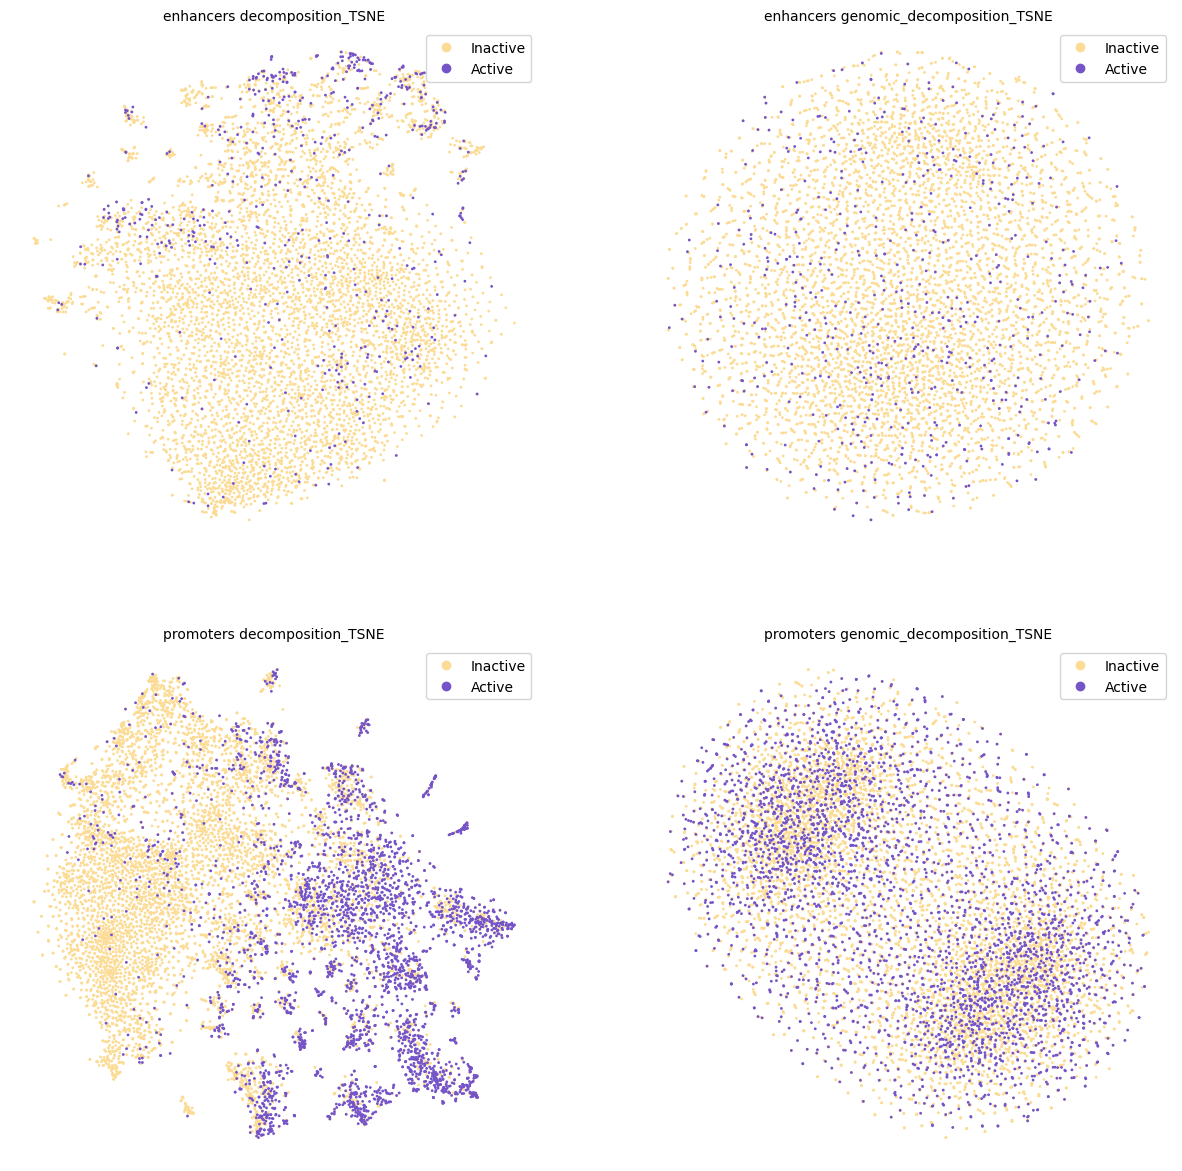

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(15, 15), dpi=100)
for i, task, clip_value in zip([0,1], data.keys(), [0.0, 0.0]):
  for j, data_dec in enumerate(['decomposition_TSNE','genomic_decomposition_TSNE']):
    u = data[task][data_dec]['X']
    y = data[task][data_dec]['y']

    colors = {'0':'#fcdb94', '1':'#7554c8'}
    cmap = mpl.colors.ListedColormap(['#fcdb94', '#7554c8'])
    
    scatter = axs[i,j].scatter(u.iloc[:,0], u.iloc[:,1], c=y, cmap=cmap, s =1) # norm=mpl.colors.LogNorm()
    axs[i,j].axis('off')
    axs[i,j].set_title(task+' '+data_dec, fontdict = {'fontsize':10})
    axs[i,j].legend(handles=scatter.legend_elements()[0], labels=['Inactive','Active'], loc=1)

plt.show()

# Build models

Import layers

In [ ]:
from typing import Tuple
from keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from keras import regularizers
from keras.models import Model, clone_model
from extra_keras_metrics import get_complete_binary_metrics

### Feed Forward Neural Network

In [ ]:
def build_binary_classification_ffnn(
    input_shape: int,
    n_hidden: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(32, activation="relu")(input_epigenomic_data)

    for _ in range(n_hidden):
        hidden = Dense(
            8,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryClassificationFFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

### Convolutional Neural Network 

In [ ]:
def build_binary_classification_cnn(
    window_size: int,
    n_hidden: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(32, kernel_size=6, activation="relu")(input_sequence_data)

    for _ in range(n_hidden):
        hidden = Conv1D(
            8,
            kernel_size=4,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)
        hidden = MaxPool1D(pool_size=2)(hidden)
        
    hidden = GlobalAveragePooling1D()(hidden)
    last_hidden_cnn = Dense(64, activation="relu")(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="BinaryClassificationCNN"
    )

    cnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return cnn, input_sequence_data, last_hidden_cnn

### Multi-Modal Neural Network

In [ ]:
def build_binary_classification_mmnn(
    input_epigenomic_data: Layer,
    input_sequence_data: Layer,
    last_hidden_ffnn: Layer,
    last_hidden_cnn: Layer,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
    output_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        
    """
    concatenation_layer = Concatenate()([
            last_hidden_ffnn,
            last_hidden_cnn
        ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="MMNN"
    )

    return mmnn

In [ ]:
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence

def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 32
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 32
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_mmnn_sequence(
  genome: Genome,
  bed: pd.DataFrame,
  X: np.ndarray,
  y: np.ndarray,
  batch_size: int = 32
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [ ]:
def get_sequence_by_model_name(model_name, X, y, genome_seq):
  if model_name == "Binary classification MMNN":
    # Build MixedSequence object for MMNN
    sequence = get_mmnn_sequence(
      genome = genome_seq,
      bed = y.reset_index(),
      X = X.values.astype(float),
      y = y.values.astype(float).flatten(),
      batch_size = X.shape[1]
    )
  elif model_name == "Binary classification CNN":
    sequence = get_cnn_sequence(
      genome = genome_seq,
      bed = y.reset_index(),
      y = y.values.astype(float).flatten()
    )
  elif model_name == "Binary classification FFNN":
    sequence = get_ffnn_sequence(
      X = X.values.astype(float),
      y = y.values.astype(float).flatten()
    )
  else: raise ValueError("Wrong model name!")
  return sequence

# Training

In [ ]:
for task in data.keys(): print(data[task]['X'].shape, data[task]['genome'].shape, data[task]['y'].shape)

(63285, 199) (63285, 1, 256, 4) (63285, 1)
(99881, 205) (99881, 1, 256, 4) (99881, 1)


Because Google Colab runs into errors when training model for more than a number of epochs using Sequence objects, we keep our number of epochs and holdouts low. Ideally, we should train on at least 10 holdouts and 100 epochs, with the EarlyStopping callback to prevent overfitting.

In [ ]:
number_of_holdouts = 5
epochs = 50
n_hidden = 1

Train models

In [ ]:
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import StratifiedShuffleSplit

def train_model_with_holdout(
    model,
    model_name,
    task: str,
    X: pd.DataFrame,
    y: pd.DataFrame,
    number_of_splits: int = 2,
    epochs: int = 10,
    genome_seq = None
):
    """ Returns training history and model evaluations as pd.Dataframe.
    
    Parameters
    ---------------------
    model,
        The model to train. None required if list of model names is passed.
    model_name : str,
        The model name as a str or list of str.
    task: str,
        The name of the task.
    X: pd.DataFrame,
        The epigenomic data.
    y: pd.DataFrame,
        The labels.
    number_of_splits: int,
        The number of holdouts.
    genome_seq:
        The Genome object.
    """

    def train(model_copy:Model, 
              train_X, val_X,
              testing_data):
        callbacks = [
                EarlyStopping(
                    "loss",
                    min_delta=0.005,
                    patience=2,
                    mode="min"
                ),
                #TQDMNotebookCallback() # how the model is performing during the training.
            ]
        validation_data = val_X
        
        history = pd.DataFrame(model_copy.fit(
            x= train_X, 
            y= None,
            validation_data = validation_data,
            epochs=epochs,
            verbose=False,
            callbacks=callbacks
        ).history)
        
        evaluations = model_copy.evaluate(testing_data, verbose=False)
        predictions = model_copy.predict(testing_data, verbose=False)

        return history, evaluations, predictions

    model_history = {}
    model_evaluations = {'evaluations':{},'predictions':{}}
    testing_data = {} # no training will be made on this data

    testing_data_generator = StratifiedShuffleSplit(
        n_splits=1,
        test_size=0.2
    )
    
    for train_index, test_index in testing_data_generator.split(X, y):
      X, testing_data['X'] = X.iloc[train_index], X.iloc[test_index]
      y, testing_data['y'] = y.iloc[train_index], y.iloc[test_index]
        
    if isinstance(model_name, str):
        testing_data[model_name] = get_sequence_by_model_name(model_name,
                                testing_data['X'], testing_data['y'], genome_seq)
    else:
        for name in model_name:
            testing_data[name] = get_sequence_by_model_name(name,
                                    testing_data['X'], testing_data['y'], genome_seq)

    holdouts_generator = StratifiedShuffleSplit(
        n_splits=number_of_splits,
        test_size=0.2
    )
    
    for holdout_number, (train_indices, val_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc=f"Training holdouts for {task}"
        ):

        # Copy model to get same architecture but train new weights on new inputs
        # if we pass only one model name
        if isinstance(model_name, str):
            models_to_train = [clone_model(model)]
            model_names = [model_name]
        else: # if its a list of model names, get new models and train them on holdouts
            number_of_features = X.shape[1]
            
            ffnn_model, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape=number_of_features, n_hidden=1)
            cnn_model, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size=window_size, n_hidden=1)
            mmnn_model = build_binary_classification_mmnn(
                input_sequence_data=input_sequence_data,
                input_epigenomic_data=input_epigenomic_data,
                last_hidden_ffnn=last_hidden_ffnn,
                last_hidden_cnn=last_hidden_cnn
              )
            models_to_train = [ffnn_model,cnn_model,mmnn_model]
            model_names = model_name

            for _model in models_to_train:
              _model.compile(
                optimizer="nadam",
                loss="binary_crossentropy",
                metrics=get_complete_binary_metrics()
              )
        
        for (_model, _model_name) in tqdm(zip(models_to_train, model_names),
                                          total=len(model_names),
                                          leave=False,
                                          desc=f'- Training models on holdout #{holdout_number}'):

            # Get the training and test data
            train_X, val_X = X.iloc[train_indices], X.iloc[val_indices]
            train_y, val_y = y.iloc[train_indices], y.iloc[val_indices]

            train_X = get_sequence_by_model_name(_model_name, val_X, val_y, genome_seq)
            val_X = get_sequence_by_model_name(_model_name, val_X, val_y, genome_seq)

            history, evaluations, predictions = train(_model, 
                                                    train_X, val_X,
                                                    testing_data[_model_name])

            model_history[(_model_name,holdout_number)] = {
              'model': _model, # store trained model
              'history' : history
            }

            model_evaluations['predictions'].setdefault(_model_name, []).append(predictions)
            model_evaluations['evaluations'].setdefault(_model_name, []).append(evaluations)
  
    for (model_name, eval) in model_evaluations['evaluations'].items():
        model_evaluations['evaluations'][model_name] = pd.DataFrame(eval,
                                                    columns=model_history[(model_name,0)]['history'].columns[:27])
    return model_history, model_evaluations

Build models and/or display models architecture. 

(Run models individually by removing comments)

In [ ]:
ffnn_model_name = "Binary classification FFNN"

for task in data.keys():

  X, y = data[task]['X'], data[task]['binary_y']
  number_of_features = X.shape[1]
  ffnn_model, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape=number_of_features, n_hidden=2)
  '''
  history, evaluations = train_model_with_holdout(model=ffnn_model, ffnn_model_name, task, 
                                                  X, y, number_of_splits=number_of_holdouts, epochs=epochs,
                                                  genome_seq = genome_sequence) 
  
  data[task]['training_history'].update( {ffnn_model_name : history} )
  data[task]['evaluation'].update( {ffnn_model_name : evaluations} )
  '''
ffnn_model.summary()

Model: "BinaryClassificationFFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 epigenomic_data (InputLayer  [(None, 205)]            0         
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 32)                6592      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                          

In [ ]:
cnn_model_name = "Binary classification CNN"

for task in data.keys():
    
  X, y = data[task]['X'], data[task]['binary_y']
  cnn_model, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size=window_size, n_hidden=n_hidden)
  
  '''
  history, evaluations = train_model_with_holdout(cnn_model, cnn_model_name, 
                                                 task, X, y, number_of_splits=number_of_holdouts, epochs=epochs,
                                                 genome_seq = genome_sequence) 

  data[task]['training_history'].update( {cnn_model_name : history} )
  data[task]['evaluation'].update( {cnn_model_name : evaluations} )
  '''
cnn_model.summary()

Model: "BinaryClassificationCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequence_data (InputLayer)  [(None, 256, 4)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 251, 32)           800       
                                                                 
 conv1d_3 (Conv1D)           (None, 248, 8)            1032      
                                                                 
 dropout_5 (Dropout)         (None, 248, 8)            0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 124, 8)           0         
 1D)                                                             
                                                                 
 global_average_pooling1d_1   (None, 8)                0         
 (GlobalAveragePooling1D)                  

In [ ]:
mmnn_model_name = "Binary classification MMNN"

for task in data.keys():
    
  X, y = data[task]['X'], data[task]['binary_y']
  number_of_features = X.shape[1]
    
  _, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape=number_of_features, n_hidden=n_hidden)
  _, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size=window_size, n_hidden=n_hidden)

  mmnn_model = build_binary_classification_mmnn(
    input_sequence_data=input_sequence_data,
    input_epigenomic_data=input_epigenomic_data,
    last_hidden_ffnn=last_hidden_ffnn,
    last_hidden_cnn=last_hidden_cnn
  )
  '''
  history, evaluations = train_model_with_holdout(mmnn_model, mmnn_model_name, 
                                                  task, X, y, number_of_splits=number_of_holdouts, epochs=epochs,
                                                  genome_seq = genome_sequence)

  data[task]['training_history'].update( {mmnn_model_name : history} )
  data[task]['evaluation'].update( {mmnn_model_name : evaluations} )
  '''
mmnn_model.summary()

Model: "MMNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_data (InputLayer)     [(None, 256, 4)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 251, 32)      800         ['sequence_data[0][0]']          
                                                                                                  
 conv1d_7 (Conv1D)              (None, 248, 8)       1032        ['conv1d_6[0][0]']               
                                                                                                  
 epigenomic_data (InputLayer)   [(None, 205)]        0           []                               
                                                                                               

Or train them together, so that the MMNN can exploit the already trained FFNN and CNN.

In [ ]:
model_names = [ffnn_model_name, cnn_model_name, mmnn_model_name]

for task in data.keys():
    history, evaluations = train_model_with_holdout(None, model_names, task, 
                                              X, y, number_of_splits=number_of_holdouts, epochs=epochs,
                                              genome_seq = genome_sequence) 

    data[task]['training_history'].update( {'all_models' : history} )
    data[task]['evaluation'].update( {'all_models' : evaluations} )

Training holdouts for enhancers:   0%|          | 0/5 [00:00<?, ?it/s]

- Training models on holdout #0:   0%|          | 0/3 [00:00<?, ?it/s]

- Training models on holdout #1:   0%|          | 0/3 [00:00<?, ?it/s]

- Training models on holdout #2:   0%|          | 0/3 [00:00<?, ?it/s]

- Training models on holdout #3:   0%|          | 0/3 [00:00<?, ?it/s]

- Training models on holdout #4:   0%|          | 0/3 [00:00<?, ?it/s]

Training holdouts for promoters:   0%|          | 0/5 [00:00<?, ?it/s]

- Training models on holdout #0:   0%|          | 0/3 [00:00<?, ?it/s]

- Training models on holdout #1:   0%|          | 0/3 [00:00<?, ?it/s]

- Training models on holdout #2:   0%|          | 0/3 [00:00<?, ?it/s]

- Training models on holdout #3:   0%|          | 0/3 [00:00<?, ?it/s]

- Training models on holdout #4:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
for task in data.keys():
    for (model_name,evalu) in data[task]['evaluation']['all_models']['evaluations'].items():
        print(f'{model_name} on {task}')
        display(evalu)

Binary classification FFNN on enhancers


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.445694  0.834109  0.721187   0.770100  0.896554  0.791963  0.744841   
1  0.558317  0.822646  0.712241   0.747574  0.881844  0.777539  0.729480   
2  0.512522  0.832758  0.827195   0.717723  0.886832  0.786664  0.768581   
3  0.406734  0.834910  0.835992   0.718386  0.898918  0.799949  0.772740   
4  0.462165  0.834410  0.744744   0.757852  0.891849  0.789825  0.751241   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.806185     0.891183   0.278813  ...              0.229900   
1           0.795344     0.878448   0.287759  ...              0.252426   
2           0.831382     0.835569   0.172805  ...              0.282277   
3           0.835178     0.834363   0.164008  ...              0.281614   
4           0.812237     0.879729   0.255256  ...              0.242148   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.136536              0.279767      0.593424   
1             0.142048              0.292342      0.574159   
2             0.094635              0.308365      0.624142   
3             0.090371              0.308016      0.629646   
4             0.127895              0.286663      0.601590   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.806185      0.745242    0.633564                   6.627522   
1               0.795344      0.729694    0.605527                   5.859535   
2               0.831382      0.770518    0.623088                   5.030649   
3               0.835178      0.774961    0.628014                   5.047138   
4               0.812237      0.751269    0.629957                   6.192199   

   negative_likelyhood_ratio       DOR  
0                   0.312857  4.159558  
1                   0.327577  3.886254  
2                   0.206811  4.930571  
3                   0.196566  5.067141  
4                   0.290153  4.325848  

[5 rows x 27 columns]

Binary classification CNN on enhancers


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.560801  0.708365  0.561950   0.566171  0.746968  0.572071  0.564053   
1  0.548203  0.713370  0.377069   0.620309  0.753906  0.585420  0.469028   
2  0.553851  0.713771  0.486059   0.589405  0.752769  0.583463  0.532767   
3  0.566335  0.704210  0.633070   0.551859  0.749069  0.575124  0.589681   
4  0.571961  0.703109  0.638437   0.549820  0.746525  0.564362  0.590824   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.672158     0.782366   0.438050  ...              0.433829   
1           0.630207     0.883346   0.622931  ...              0.379691   
2           0.657461     0.828862   0.513941  ...              0.410595   
3           0.686618     0.740166   0.366930  ...              0.448141   
4           0.687116     0.735795   0.361563  ...              0.450180   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.220571              0.383599      0.392809   
1             0.262767              0.357414      0.306360   
2             0.238613              0.372401      0.363110   
3             0.200358              0.390486      0.418119   
4             0.198950              0.391467      0.419270   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.672158      0.564057    0.345600                   2.582090   
1               0.630207      0.483631    0.357542                   3.232363   
2               0.657461      0.535244    0.350792                   2.840160   
3               0.686618      0.591071    0.351500                   2.436437   
4               0.687116      0.592474    0.350870                   2.416447   

   negative_likelyhood_ratio       DOR  
0                   0.559904  2.050252  
1                   0.705195  1.704218  
2                   0.620056  1.919373  
3                   0.495740  2.190992  
4                   0.491390  2.196075  

[5 rows x 27 columns]

Binary classification MMNN on enhancers


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.469057  0.830005  0.755330   0.742706  0.889312  0.775595  0.748965   
1  0.714241  0.816239  0.672134   0.753846  0.873332  0.769648  0.710649   
2  0.661195  0.829654  0.815566   0.716344  0.878161  0.781354  0.762741   
3  0.437924  0.832758  0.825108   0.718515  0.894701  0.795120  0.768131   
4  0.475393  0.830655  0.760996   0.741429  0.889574  0.784006  0.751085   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.811539     0.867747   0.244670  ...              0.257294   
1           0.780603     0.889073   0.327866  ...              0.246154   
2           0.826170     0.836775   0.184434  ...              0.283656   
3           0.830866     0.836624   0.174892  ...              0.281485   
4           0.813429     0.865863   0.239004  ...              0.258571   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.124734              0.295001      0.598676   
1             0.157105              0.288888      0.551168   
2             0.100235              0.309090      0.616477   
3             0.095560              0.307948      0.623549   
4             0.122432              0.295695      0.601390   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.811539      0.748992    0.617972                   5.711239   
1               0.780603      0.711818    0.596741                   6.059242   
2               0.826170      0.764346    0.616109                   4.996561   
3               0.830866      0.769969    0.622955                   5.050359   
4               0.813429      0.751149    0.618998                   5.673263   

   negative_likelyhood_ratio       DOR  
0                   0.281960  4.306123  
1                   0.368773  3.557954  
2                   0.220411  4.752754  
3                   0.209045  4.912471  
4                   0.276030  4.359900  

[5 rows x 27 columns]

Binary classification FFNN on promoters


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.376644  0.843070  0.767556   0.765616  0.905495  0.812028  0.766585   
1  0.464728  0.830505  0.719099   0.762530  0.893579  0.783696  0.740178   
2  0.413149  0.830205  0.711645   0.766009  0.898148  0.792763  0.737827   
3  0.516152  0.837113  0.837632   0.721830  0.892596  0.799259  0.775431   
4  0.468051  0.836112  0.843000   0.717968  0.895218  0.797848  0.775477   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.824396     0.881236   0.232444  ...              0.234384   
1           0.802956     0.886812   0.280901  ...              0.237470   
2           0.800886     0.890128   0.288355  ...              0.233991   
3           0.837241     0.836850   0.162368  ...              0.278170   
4           0.837815     0.832630   0.157000  ...              0.282032   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.117634              0.282309      0.621514   
1             0.138002              0.284047      0.587526   
2             0.140695              0.282087      0.584568   
3             0.089306              0.306198      0.633228   
4             0.087010              0.308236      0.633289   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.824396      0.766585    0.647982                   6.462858   
1               0.802956      0.740496    0.624528                   6.353157   
2               0.800886      0.738326    0.625313                   6.477033   
3               0.837241      0.777578    0.632523                   5.134121   
4               0.837815      0.777976    0.630958                   5.036741   

   negative_likelyhood_ratio       DOR  
0                   0.263770  4.694633  
1                   0.316753  4.075005  
2                   0.323948  4.022256  
3                   0.194022  5.144059  
4                   0.188559  5.165793  

[5 rows x 27 columns]

Binary classification CNN on promoters


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.551799  0.710767  0.505144   0.579442  0.746902  0.567276  0.539748   
1  0.551905  0.713170  0.527658   0.580069  0.751044  0.585216  0.552623   
2  0.552460  0.704510  0.421202   0.582955  0.746548  0.568838  0.489050   
3  0.556088  0.709616  0.518264   0.574926  0.746165  0.571215  0.545127   
4  0.551103  0.709766  0.417176   0.596970  0.748754  0.571254  0.491136   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.659919     0.814695   0.494856  ...              0.420558   
1           0.667295     0.806933   0.472342  ...              0.419931   
2           0.634452     0.847702   0.578798  ...              0.417045   
3           0.662297     0.806330   0.481735  ...              0.425074   
4           0.637412     0.857649   0.582824  ...              0.403030   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.234890              0.377207      0.369627   
1             0.228308              0.376905      0.381810   
2             0.256559              0.375513      0.323671   
3             0.231929              0.379384      0.374690   
4             0.255657              0.368745      0.325500   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.659919      0.541019    0.344552                   2.726009   
1               0.667295      0.553243    0.351761                   2.733026   
2               0.634452      0.495522    0.326396                   2.765632   
3               0.662297      0.545860    0.342997                   2.676018   
4               0.637412      0.499041    0.341313                   2.930610   

   negative_likelyhood_ratio       DOR  
0                   0.607413  1.940479  
1                   0.585355  2.005668  
2                   0.682785  1.735616  
3                   0.597442  1.961184  
4                   0.679560  1.757954  

[5 rows x 27 columns]

Binary classification MMNN on promoters


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.384237  0.837864  0.742806   0.766934  0.900141  0.802210  0.754677   
1  0.487548  0.823847  0.705681   0.753902  0.887001  0.770734  0.728995   
2  0.440138  0.829654  0.715968   0.762222  0.893241  0.781763  0.738372   
3  0.514379  0.829404  0.839422   0.707198  0.885284  0.788203  0.767657   
4  0.557919  0.834710  0.832414   0.719366  0.883990  0.785106  0.771772   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.814357     0.885908   0.257194  ...              0.233066   
1           0.794626     0.883572   0.294319  ...              0.246097   
2           0.801541     0.887114   0.284032  ...              0.237778   
3           0.831881     0.824341   0.160579  ...              0.292802   
4           0.834142     0.835870   0.167586  ...              0.280634   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.127958              0.281564      0.606009   
1             0.144098              0.288856      0.573558   
2             0.139285              0.284219      0.585253   
3             0.089630              0.313871      0.622925   
4             0.092010              0.307499      0.628362   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.814357      0.754773    0.638976                   6.510586   
1               0.794626      0.729393    0.609804                   6.061083   
2               0.801541      0.738733    0.622937                   6.342384   
3               0.831881      0.770478    0.617567                   4.778686   
4               0.834142      0.773828    0.627356                   5.071683   

   negative_likelyhood_ratio       DOR  
0                   0.290317  4.386683  
1                   0.333102  3.869172  
2                   0.320175  4.038826  
3                   0.194796  4.948168  
4                   0.200493  5.029257  

[5 rows x 27 columns]

# Evaluation
In this context, we consider evaluation the performance of each model on the same test data sequence, on which the model *has not* been trained. The test data set is made by 20% of the total data. 

> Each testing data sequence was made by extracting the same indices from the datasets, even if the final Sequence object on which the model is evaluated is obviously different for each model.

In [ ]:
for task in data.keys():
  for i, ((model_name,holdout_number),values) in enumerate(data[task]['training_history']['all_models'].items()):
    print(f"Training History for {task} from {model_name}")
    display(values['history']) 

Training History for enhancers from Binary classification FFNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.515307  0.757462  0.662691   0.632515  0.824086  0.687654  0.647252   
1   0.417397  0.822727  0.697913   0.755497  0.880778  0.777485  0.725564   
2   0.393803  0.831112  0.705367   0.771976  0.893242  0.800277  0.737170   
3   0.389282  0.831800  0.698099   0.778147  0.896003  0.802627  0.735953   
4   0.377596  0.835179  0.707976   0.780723  0.901314  0.815931  0.742572   
5   0.376957  0.838683  0.713381   0.786360  0.901419  0.818954  0.748095   
6   0.371645  0.841186  0.706299   0.797559  0.905052  0.825443  0.749160   
7   0.366940  0.841624  0.709467   0.796610  0.907446  0.830716  0.750517   
8   0.358458  0.843502  0.709840   0.801389  0.911835  0.835178  0.752841   
9   0.350854  0.849947  0.728848   0.805727  0.915663  0.843510  0.765362   
10  0.346081  0.850698  0.721208   0.813025  0.918168  0.848965  0.764369   
11  0.339310  0.856955  0.737607   0.818445  0.921678  0.853756  0.775926   
12  0.336673  0.856142  0.729966   0.821691  0.922849  0.857355  0.773118   
13  0.328569  0.861085  0.739657   0.828255  0.926513  0.864893  0.781453   
14  0.322547  0.860647  0.737607   0.828553  0.928497  0.869381  0.780440   
15  0.322027  0.862587  0.737421   0.834106  0.928784  0.870373  0.782789   
16  0.315802  0.865465  0.737607   0.842128  0.931506  0.876944  0.786410   
17  0.306306  0.871222  0.758666   0.842160  0.935556  0.882472  0.798235   
18  0.302206  0.871660  0.749720   0.850349  0.937831  0.887331  0.796870   
19  0.301095  0.872724  0.751211   0.852220  0.938633  0.886521  0.798534   
20  0.288238  0.876729  0.757547   0.858682  0.941695  0.897961  0.804950   
21  0.287723  0.877792  0.759411   0.860249  0.942510  0.896723  0.806691   
22  0.285272  0.878105  0.759225   0.861311  0.944082  0.900056  0.807052   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.734030     0.805370   0.337309  ...                  0.224267   
1            0.791867     0.885822   0.302087  ...                  0.231417   
2            0.800022     0.894677   0.294633  ...                  0.214510   
3            0.798743     0.899388   0.301901  ...                  0.220563   
4            0.803729     0.899482   0.292024  ...                  0.203013   
5            0.807703     0.902025   0.286619  ...                  0.195761   
6            0.807836     0.909374   0.293701  ...                  0.196712   
7            0.808949     0.908431   0.290533  ...                  0.191368   
8            0.810454     0.911069   0.290160  ...                  0.199660   
9            0.820006     0.911163   0.271152  ...                  0.186695   
10           0.818682     0.916156   0.278792  ...                  0.184165   
11           0.827447     0.917287   0.262393  ...                  0.147878   
12           0.824946     0.919925   0.270034  ...                  0.162140   
13           0.831063     0.922468   0.260343  ...                  0.167870   
14           0.830226     0.922845   0.262393  ...                  0.159739   
15           0.831640     0.925860   0.262579  ...                  0.148193   
16           0.833853     0.930099   0.262393  ...                  0.136570   
17           0.843393     0.928121   0.241334  ...                  0.146356   
18           0.841511     0.933302   0.250280  ...                  0.151446   
19           0.842681     0.934150   0.248789  ...                  0.107856   
20           0.847262     0.936976   0.242452  ...                  0.146840   
21           0.848523     0.937635   0.240589  ...                  0.107462   
22           0.848713     0.938201   0.240775  ...                  0.118740   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.138637                  0.276562          0.592432   
1                  0.118515                  0.280647          0.621781   
2            

Training History for enhancers from Binary classification CNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.628585  0.663601  0.010809   0.460317  0.587617  0.396596  0.021122   
1  0.600417  0.663225  0.162132   0.495444  0.669085  0.459108  0.244313   
2  0.584959  0.669983  0.236303   0.518822  0.694255  0.480507  0.324712   
3  0.571909  0.679494  0.330786   0.536903  0.714092  0.499925  0.409363   
4  0.565295  0.692447  0.394894   0.559546  0.725380  0.524319  0.463018   
5  0.561368  0.696515  0.432352   0.562561  0.732512  0.543994  0.488936   
6  0.558179  0.703335  0.437570   0.576762  0.737169  0.546753  0.497616   
7  0.556308  0.704712  0.453597   0.576641  0.740472  0.556426  0.507771   
8  0.553687  0.709217  0.449683   0.587533  0.744668  0.564893  0.509448   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.502201     0.993594   0.989191  ...                  0.495238   
1           0.539333     0.916533   0.837868  ...                  0.484950   
2           0.562758     0.889213   0.763697  ...                  0.468939   
3           0.593278     0.855770   0.669214  ...                  0.466849   
4           0.618879     0.842864   0.605106  ...                  0.448941   
5           0.631202     0.830052   0.567648  ...                  0.432290   
6           0.637626     0.837683   0.562430  ...                  0.427608   
7           0.642625     0.831653   0.546403  ...                  0.390972   
8           0.645049     0.840415   0.550317  ...                  0.425089   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.333524                  0.413226          0.019378   
1                 0.321272                  0.408250          0.103599   
2                 0.288039                  0.400521          0.243785   
3                 0.209701                  0.399513          0.401378   
4                 0.230776                  0.390891          0.374061   
5                 0.226750                  0.382878          0.382970   
6                 0.226712                  0.380624          0.383675   
7                 0.246932                  0.362921          0.346137   
8                 0.216003                  0.379410          0.401677   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.504978          0.099855        0.171238   
1                   0.530079          0.243159        0.193779   
2                   0.585994          0.406176        0.243022   
3                   0.672472          0.574426        0.323451   
4                   0.658222          0.544499        0.320283   
5                   0.666262          0.554003        0.340960   
6                   0.667361          0.554842        0.345680   
7                   0.650303          0.520608        0.362096   
8                   0.678905          0.573140        0.358908   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       2.016218                       0.989945  1.020113  
1                       2.100977                       0.936366  1.128015  
2                       2.240252                       0.800322  1.415424  
3                       2.259143                       0.524901  2.053178  
4                       2.428167                       0.593483  1.925875  
5                       2.597892                       0.580092  1.996364  
6                       2.647992                       0.579965  2.006262  
7                       3.081493                       0.648653  1.859618  
8                       2.675406                       0.545023  2.114341  

[9 rows x 54 columns]

Training History for enhancers from Binary classification MMNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.388513  0.826356  0.737794   0.743195  0.895761  0.832577  0.740484   
1  0.277530  0.885176  0.783638   0.861857  0.946367  0.906591  0.820888   
2  0.259360  0.892184  0.792583   0.874563  0.952821  0.917541  0.831557   
3  0.251786  0.894500  0.795565   0.878757  0.955260  0.923000  0.835094   
4  0.244398  0.898066  0.803392   0.882497  0.957673  0.927207  0.841089   
5  0.239562  0.900194  0.802646   0.889325  0.959000  0.929191  0.843765   
6  0.235972  0.902572  0.806373   0.893086  0.959889  0.932513  0.847517   
7  0.228211  0.905262  0.812710   0.895483  0.962978  0.935420  0.852091   
8  0.227508  0.904887  0.811964   0.895029  0.962693  0.936564  0.851475   
9  0.224549  0.906326  0.811219   0.899938  0.963414  0.937999  0.853278   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.804460     0.871126   0.262206  ...                  0.153658   
1           0.860071     0.936505   0.216362  ...                  0.117047   
2           0.867559     0.942534   0.207417  ...                  0.142059   
3           0.870039     0.944512   0.204435  ...                  0.106133   
4           0.874659     0.945926   0.196608  ...                  0.097826   
5           0.876076     0.949505   0.197354  ...                  0.079534   
6           0.878787     0.951201   0.193627  ...                  0.101386   
7           0.882379     0.952049   0.187290  ...                  0.096984   
8           0.881912     0.951861   0.188036  ...                  0.099370   
9           0.882811     0.954404   0.188781  ...                  0.108658   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.081208                  0.232510          0.727802   
1                 0.086770                  0.205635          0.741556   
2                 0.071442                  0.224394          0.751836   
3                 0.080026                  0.196783          0.760976   
4                 0.080269                  0.189709          0.765892   
5                 0.084541                  0.172867          0.769137   
6                 0.075748                  0.192779          0.772031   
7                 0.071966                  0.188974          0.782008   
8                 0.072392                  0.191048          0.779595   
9                 0.063584                  0.198873          0.788951   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.880823          0.842469        0.765134   
1                   0.883645          0.852139        0.796183   
2                   0.893430          0.858340        0.786499   
3                   0.893176          0.864741        0.813841   
4                   0.894737          0.868072        0.821905   
5                   0.893952          0.870841        0.835925   
6                   0.898731          0.871753        0.822866   
7                   0.903679          0.878016        0.831050   
8                   0.902694          0.876472        0.828238   
9                   0.909556          0.882074        0.827758   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio    val_DOR  
0                      10.895803                       0.174844   7.390911  
1                      14.922671                       0.187958   7.594370  
2                      11.946939                       0.152200   8.383535  
3                      16.660608                       0.172077   8.361170  
4                      18.243322                       0.172645   8.500045  
5                      22.894190                       0.182683   8.429704  
6                      17.533272                       0.162125   8.874661  
7                      18.418894                       0.153402   9.382002  
8                      17.929077                       0.154381  

Training History for enhancers from Binary classification FFNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.471632  0.780740  0.655982   0.679799  0.851276  0.720893  0.667678   
1   0.394204  0.824604  0.761461   0.728472  0.893333  0.790384  0.744601   
2   0.382867  0.829110  0.744130   0.746216  0.898226  0.799452  0.745171   
3   0.370643  0.835930  0.752143   0.757508  0.905287  0.810360  0.754816   
4   0.364219  0.838496  0.752702   0.763083  0.908144  0.817199  0.757857   
5   0.356646  0.839997  0.759597   0.762867  0.911706  0.828015  0.761229   
6   0.355921  0.843126  0.758107   0.770893  0.912900  0.825508  0.764446   
7   0.349626  0.846505  0.770965   0.771684  0.915893  0.834216  0.771325   
8   0.343069  0.849071  0.772270   0.776903  0.919401  0.840425  0.774579   
9   0.337080  0.846943  0.767797   0.774436  0.921249  0.845197  0.771102   
10  0.332705  0.849697  0.767611   0.781001  0.923314  0.848792  0.774248   
11  0.325371  0.853201  0.781588   0.781297  0.926338  0.853719  0.781442   
12  0.326321  0.854014  0.782147   0.782876  0.926559  0.855289  0.782511   
13  0.320345  0.854077  0.782892   0.782601  0.928981  0.860945  0.782746   
14  0.312462  0.857706  0.786433   0.789080  0.932534  0.865025  0.787754   
15  0.310482  0.858019  0.786806   0.789602  0.933378  0.866279  0.788201   
16  0.307131  0.859708  0.784570   0.794940  0.934937  0.872808  0.789720   
17  0.299361  0.862399  0.790347   0.797930  0.937973  0.879427  0.794120   
18  0.295405  0.864214  0.793701   0.800263  0.939414  0.881996  0.796969   
19  0.291227  0.866028  0.788669   0.807788  0.940927  0.883632  0.798114   
20  0.284014  0.866904  0.795378   0.805739  0.943613  0.890287  0.800525   
21  0.279744  0.866779  0.791092   0.808110  0.944813  0.889902  0.799510   
22  0.278694  0.870784  0.800969   0.811709  0.946383  0.894030  0.806303   
23  0.267907  0.873287  0.801714   0.817405  0.949502  0.901005  0.809483   
24  0.266303  0.874101  0.803951   0.817975  0.950142  0.903689  0.810902   
25  0.260982  0.876103  0.799665   0.825828  0.951671  0.905601  0.812536   
26  0.256686  0.877041  0.794074   0.832064  0.953069  0.908323  0.812625   
27  0.254612  0.878606  0.801342   0.831078  0.954333  0.910824  0.815939   
28  0.250010  0.877479  0.792956   0.833987  0.955252  0.913729  0.812954   
29  0.246002  0.878356  0.789601   0.838678  0.956569  0.915260  0.813400   
30  0.241538  0.880045  0.791278   0.841959  0.957835  0.917087  0.815832   
31  0.236450  0.880984  0.788856   0.846262  0.959535  0.922636  0.816551   
32  0.235042  0.881234  0.786992   0.848333  0.959666  0.922076  0.816512   
33  0.235226  0.882298  0.787738   0.850674  0.959602  0.921271  0.817997   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.749894     0.843806   0.344018  ...                  0.287353   
1            0.808992     0.856524   0.238539  ...                  0.259424   
2            0.808099     0.872068   0.255870  ...                  0.239886   
3            0.815214     0.878285   0.247857  ...                  0.238570   
4            0.817284     0.881865   0.247298  ...                  0.235504   
5            0.820119     0.880641   0.240403  ...                  0.228193   
6            0.822106     0.886105   0.241893  ...                  0.230511   
7            0.827828     0.884691   0.229035  ...                  0.224733   
8            0.830082     0.887895   0.227730  ...                  0.212116   
9            0.827375     0.886952   0.232203  ...                  0.211278   
10           0.829401     0.891192   0.232389  ...                  0.221793   
11           0.835495     0.889402   0.218412  ...                  0.204074   
12           0.836245     0.890344   0.217853  ...                  0.214590   
13           0.836477     0.890061   0.217108  ...                  0.202980   
14           0.840084     0.893735   0.213567  ...                  0.201376   
15           0.840412     0.8940

Training History for enhancers from Binary classification CNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.630737  0.656279  0.029817   0.357942  0.584330  0.387581  0.055049   
1   0.605826  0.660660  0.138464   0.481529  0.659717  0.455950  0.215082   
2   0.593295  0.668669  0.199031   0.517191  0.686101  0.477705  0.287445   
3   0.579357  0.678681  0.271524   0.543049  0.709484  0.497257  0.362033   
4   0.568613  0.690069  0.314201   0.569787  0.725199  0.522037  0.405045   
5   0.560334  0.699956  0.363399   0.585761  0.736007  0.542753  0.448534   
6   0.556725  0.707277  0.397876   0.596036  0.740819  0.552450  0.477202   
7   0.554841  0.708341  0.413157   0.594529  0.743522  0.559170  0.487521   
8   0.551835  0.714786  0.418934   0.609544  0.747453  0.573874  0.496576   
9   0.549225  0.717289  0.432911   0.611638  0.750534  0.579413  0.506984   
10  0.549353  0.718916  0.435893   0.614879  0.749830  0.581710  0.510142   
11  0.546979  0.718228  0.439620   0.611933  0.752921  0.586700  0.511658   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.501390     0.972963   0.970183  ...                  0.486486   
1            0.531550     0.924635   0.861536  ...                  0.514886   
2            0.552554     0.906076   0.800969  ...                  0.471974   
3            0.578014     0.884503   0.728476  ...                  0.432303   
4            0.597138     0.880075   0.685799  ...                  0.400140   
5            0.616744     0.870089   0.636601  ...                  0.388121   
6            0.630780     0.863683   0.602125  ...                  0.376888   
7            0.635358     0.857560   0.586843  ...                  0.336915   
8            0.641638     0.864343   0.581066  ...                  0.398465   
9            0.646978     0.861046   0.567089  ...                  0.383892   
10           0.648940     0.861988   0.564107  ...                  0.338597   
11           0.649344     0.859067   0.560380  ...                  0.351443   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.334112                  0.408990          0.013976   
1                  0.330240                  0.422794          0.048940   
2                  0.270901                  0.401984          0.292888   
3                  0.279084                  0.382884          0.265060   
4                  0.309781                  0.367366          0.144637   
5                  0.267130                  0.361536          0.294955   
6                  0.273489                  0.356065          0.275509   
7                  0.306718                  0.336344          0.148837   
8                  0.237973                  0.366555          0.365306   
9                  0.237536                  0.359479          0.367203   
10                 0.268894                  0.337184          0.286419   
11                 0.255679                  0.343565          0.324528   

    val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                    0.503690          0.085282        0.179401   
1                    0.511962          0.158247        0.154874   
2                    0.608741          0.457710        0.257124   
3                    0.602126          0.434197        0.288612   
4                    0.553051          0.309882        0.290080   
5                    0.623248          0.471184        0.344749   
6                    0.614758          0.453873        0.349623   
7                    0.559829          0.326750        0.356368   
8                    0.660274          0.538418        0.363562   
9                    0.663085          0.541625        0.378572   
10                   0.624387          0.471156        0.392509   
11                   0.642955          0.505357        0.392879   

    val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                        2.088065       

Training History for enhancers from Binary classification MMNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.340908  0.840748  0.719530   0.787798  0.922445  0.853936  0.752118   
1   0.228985  0.886240  0.825382   0.834087  0.962727  0.928194  0.829711   
2   0.215584  0.891559  0.828736   0.845277  0.966462  0.935144  0.836925   
3   0.205595  0.893499  0.839359   0.842814  0.968699  0.939215  0.841083   
4   0.202948  0.892935  0.839173   0.841525  0.969168  0.940313  0.840347   
5   0.198314  0.893811  0.840291   0.842961  0.970155  0.942345  0.841624   
6   0.191169  0.895939  0.828736   0.856675  0.971689  0.946086  0.842474   
7   0.191053  0.897378  0.830227   0.859375  0.971709  0.945558  0.844550   
8   0.185641  0.900382  0.849236   0.853371  0.973442  0.948052  0.851298   
9   0.183318  0.900945  0.835818   0.864662  0.973913  0.950007  0.849995   
10  0.180153  0.900194  0.838054   0.860999  0.974253  0.950918  0.849372   
11  0.179083  0.902134  0.844763   0.861132  0.974862  0.952035  0.852869   
12  0.175485  0.902572  0.857436   0.853143  0.975529  0.952703  0.855284   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.810778     0.902025   0.280470  ...                  0.173046   
1            0.871193     0.917004   0.174618  ...                  0.167474   
2            0.876026     0.923316   0.171264  ...                  0.129120   
3            0.880113     0.920867   0.160641  ...                  0.190256   
4            0.879643     0.920113   0.160827  ...                  0.176792   
5            0.880579     0.920867   0.159709  ...                  0.120256   
6            0.879323     0.929910   0.171264  ...                  0.101423   
7            0.880775     0.931324   0.169773  ...                  0.138956   
8            0.887736     0.926236   0.150764  ...                  0.096761   
9            0.884843     0.933867   0.164182  ...                  0.087155   
10           0.884830     0.931606   0.161946  ...                  0.069642   
11           0.887949     0.931135   0.155237  ...                  0.153010   
12           0.891412     0.925389   0.142564  ...                  0.087065   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.077092                  0.245420          0.721361   
1                  0.069493                  0.241786          0.736984   
2                  0.080754                  0.214928          0.744695   
3                  0.046645                  0.256304          0.752225   
4                  0.053552                  0.247832          0.753515   
5                  0.076084                  0.208152          0.758811   
6                  0.085435                  0.192811          0.753794   
7                  0.066275                  0.222166          0.762543   
8                  0.086463                  0.188779          0.754710   
9                  0.086633                  0.180120          0.760283   
10                 0.092656                  0.162847          0.758481   
11                 0.058937                  0.232066          0.763855   
12                 0.087925                  0.180037          0.757780   

    val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                    0.879868          0.838205        0.749862   
1                    0.888637          0.848737        0.763034   
2                    0.887191          0.853835        0.790126   
3                    0.902595          0.860161        0.763099   
4                    0.900698          0.860267        0.769656   
5                    0.894062          0.863027        0.803660   
6                    0.888441          0.860424        0.813142   
7                    0.899306          0.865286        0.794769   
8                    0.888315          0.861189        0.816776   
9                    0.890112          0.865068        0.826212   
10                  

Training History for enhancers from Binary classification FFNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.487132  0.762155  0.488632   0.712694  0.845994  0.718277  0.579768   
1   0.409941  0.794193  0.572866   0.755097  0.884144  0.774827  0.651478   
2   0.386801  0.836431  0.794819   0.738145  0.895568  0.799249  0.765434   
3   0.381842  0.838871  0.802646   0.739653  0.897638  0.801471  0.769863   
4   0.371307  0.842751  0.809169   0.744641  0.903254  0.808194  0.775565   
5   0.365508  0.846130  0.815132   0.748844  0.905667  0.813851  0.780584   
6   0.359708  0.846380  0.822400   0.746069  0.908670  0.818240  0.782377   
7   0.356468  0.845254  0.822959   0.743560  0.910936  0.823803  0.781247   
8   0.350893  0.848382  0.825009   0.748943  0.912822  0.830657  0.785138   
9   0.344243  0.851887  0.835073   0.751467  0.916589  0.833749  0.791067   
10  0.339874  0.852763  0.837495   0.752134  0.918254  0.837026  0.792523   
11  0.336110  0.856893  0.839918   0.759393  0.919983  0.841914  0.797629   
12  0.330241  0.856767  0.841036   0.758615  0.922566  0.846862  0.797702   
13  0.324487  0.860647  0.848490   0.763030  0.925551  0.852496  0.803494   
14  0.321863  0.861586  0.853336   0.762658  0.926892  0.854872  0.805453   
15  0.313716  0.864652  0.852963   0.769114  0.930297  0.859765  0.808872   
16  0.313255  0.862337  0.860417   0.760877  0.929828  0.859871  0.807591   
17  0.307488  0.865403  0.865822   0.764522  0.931997  0.863073  0.812025   
18  0.302046  0.866654  0.863772   0.768020  0.934033  0.869758  0.813087   
19  0.299352  0.871973  0.871226   0.775290  0.935120  0.866241  0.820463   
20  0.293992  0.871973  0.874767   0.773566  0.937489  0.871915  0.821060   
21  0.287860  0.873287  0.884085   0.771759  0.938691  0.874007  0.824112   
22  0.287043  0.873162  0.883712   0.771684  0.939788  0.875345  0.823908   
23  0.279527  0.876291  0.891912   0.774058  0.942244  0.877901  0.828816   
24  0.275813  0.878606  0.896757   0.776379  0.943121  0.880930  0.832238   
25  0.268693  0.879044  0.897689   0.776810  0.945546  0.884953  0.832887   
26  0.266848  0.879294  0.903280   0.774652  0.946026  0.886946  0.834036   
27  0.263071  0.881985  0.907007   0.778222  0.946768  0.887429  0.837694   
28  0.255225  0.885552  0.912411   0.782734  0.948996  0.892890  0.842613   
29  0.256013  0.882360  0.911480   0.776842  0.949035  0.891860  0.838793   
30  0.254927  0.883424  0.918934   0.775436  0.948765  0.890650  0.841109   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.694528     0.900424   0.511368  ...                  0.188655   
1            0.739471     0.906076   0.427134  ...                  0.256308   
2            0.826143     0.857466   0.205181  ...                  0.253426   
3            0.829915     0.857183   0.197354  ...                  0.238279   
4            0.834448     0.859727   0.190831  ...                  0.236856   
5            0.838466     0.861799   0.184868  ...                  0.230360   
6            0.840451     0.858502   0.177600  ...                  0.229782   
7            0.839742     0.856524   0.177041  ...                  0.226452   
8            0.842604     0.860198   0.174991  ...                  0.243404   
9            0.847729     0.860386   0.164927  ...                  0.216010   
10           0.848988     0.860480   0.162505  ...                  0.217202   
11           0.852696     0.865473   0.160082  ...                  0.210536   
12           0.852878     0.864720   0.158964  ...                  0.214867   
13           0.857641     0.866792   0.151510  ...                  0.213989   
14           0.859546     0.865756   0.146664  ...                  0.213358   
15           0.861762     0.870561   0.147037  ...                  0.208084   
16           0.861862     0.863307   0.139583  ...                  0.224084   
17           0.865506     0.865191   0.134178  ...                  0.216266   
18           0.865942  

Training History for enhancers from Binary classification CNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.626820  0.662349  0.027208   0.453416  0.594498  0.404666  0.051336   
1  0.601357  0.662474  0.147223   0.491294  0.667818  0.457070  0.226556   
2  0.586887  0.670734  0.226612   0.522337  0.693229  0.481688  0.316090   
3  0.575036  0.682811  0.294633   0.551832  0.712072  0.509777  0.384157   
4  0.566167  0.697203  0.352404   0.580952  0.725839  0.533960  0.438696   
5  0.561113  0.704900  0.387999   0.592487  0.733768  0.549328  0.468919   
6  0.558621  0.706839  0.403280   0.593364  0.737521  0.557666  0.480195   
7  0.555866  0.707590  0.405143   0.594802  0.740674  0.567019  0.481986   
8  0.554923  0.710344  0.418561   0.598136  0.742071  0.567350  0.492490   
9  0.552781  0.710782  0.418934   0.599147  0.744908  0.569610  0.493091   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.505314     0.983420   0.972792  ...                  0.493827   
1           0.535081     0.922939   0.852777  ...                  0.481081   
2           0.560927     0.895243   0.773388  ...                  0.459057   
3           0.586836     0.879039   0.705367  ...                  0.417002   
4           0.611953     0.871503   0.647596  ...                  0.374643   
5           0.626548     0.865097   0.612001  ...                  0.392078   
6           0.631786     0.860292   0.596720  ...                  0.365183   
7           0.632812     0.860480   0.594857  ...                  0.338560   
8           0.638202     0.857843   0.581439  ...                  0.343430   
9           0.638624     0.858314   0.581066  ...                  0.401836   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.315476                  0.412548          0.138737   
1                 0.331433                  0.406379          0.034632   
2                 0.330466                  0.395758          0.039272   
3                 0.295577                  0.375513          0.206891   
4                 0.292012                  0.354969          0.213264   
5                 0.253464                  0.363458          0.330743   
6                 0.273264                  0.350336          0.275137   
7                 0.296444                  0.337165          0.191461   
8                 0.277884                  0.339591          0.258501   
9                 0.233976                  0.368187          0.373132   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.540661          0.284987        0.190697   
1                   0.509506          0.136262        0.187486   
2                   0.511599          0.148245        0.210477   
3                   0.577512          0.376253        0.287421   
4                   0.585228          0.391026        0.333346   
5                   0.641677          0.505555        0.354459   
6                   0.615909          0.455527        0.361553   
7                   0.578670          0.374698        0.364996   
8                   0.609940          0.443014        0.378685   
9                   0.664425          0.545762        0.364188   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       2.027648                       0.911690  1.177040  
1                       2.133772                       0.980663  1.038761  
2                       2.331050                       0.976390  1.047498  
3                       2.765651                       0.830054  1.366933  
4                       3.302022                       0.815913  1.410964  
5                       3.067221                       0.671636  1.790781  
6                       3.438803                       0.743831  1.603552  
7                       3.864770                       0.833516  1.373437  
8                       3.781910                       0.761249  1.563708 

Training History for enhancers from Binary classification MMNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.409750  0.772980  0.590757   0.688831  0.879389  0.768626  0.636035   
1   0.254460  0.884676  0.887067   0.793730  0.951892  0.899794  0.837807   
2   0.239781  0.890745  0.909057   0.794980  0.955193  0.904523  0.848200   
3   0.231616  0.895188  0.923220   0.796847  0.956814  0.908181  0.855392   
4   0.224654  0.897503  0.928997   0.798622  0.958886  0.912336  0.858890   
5   0.220023  0.900194  0.930861   0.803184  0.959954  0.914644  0.862322   
6   0.218333  0.900444  0.938874   0.799556  0.959269  0.912442  0.863632   
7   0.213227  0.902634  0.942042   0.802381  0.960901  0.916538  0.866621   
8   0.213155  0.903260  0.944092   0.802598  0.961153  0.917524  0.867614   
9   0.208001  0.905262  0.947633   0.804843  0.962444  0.919710  0.870421   
10  0.208566  0.903323  0.945770   0.801864  0.962110  0.919313  0.867892   
11  0.206018  0.905513  0.950801   0.803718  0.963712  0.922218  0.871094   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.727927     0.865097   0.409243  ...                  0.190178   
1            0.885267     0.883467   0.112933  ...                  0.183365   
2            0.895273     0.881488   0.090943  ...                  0.180821   
3            0.902119     0.881017   0.076780  ...                  0.181400   
4            0.905290     0.881583   0.071003  ...                  0.176714   
5            0.907776     0.884691   0.069139  ...                  0.178821   
6            0.909946     0.881017   0.061126  ...                  0.175954   
7            0.912378     0.882713   0.057958  ...                  0.178864   
8            0.913356     0.882619   0.055908  ...                  0.177215   
9            0.915738     0.883844   0.052367  ...                  0.178071   
10           0.913817     0.881865   0.054230  ...                  0.184389   
11           0.916710     0.882619   0.049199  ...                  0.174636   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.069929                  0.256256          0.720037   
1                  0.055930                  0.252004          0.745034   
2                  0.051104                  0.250398          0.753767   
3                  0.038807                  0.250765          0.770015   
4                  0.039726                  0.247782          0.772734   
5                  0.031555                  0.249127          0.781815   
6                  0.039895                  0.247294          0.773145   
7                  0.026731                  0.249155          0.788052   
8                  0.030146                  0.248103          0.785073   
9                  0.026714                  0.248649          0.788782   
10                 0.021136                  0.252648          0.790142   
11                 0.021073                  0.246447          0.799164   

    val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                    0.881847          0.837714        0.739894   
1                    0.896577          0.854781        0.760706   
2                    0.901658          0.860646        0.768076   
3                    0.912217          0.871791        0.779793   
4                    0.912935          0.873317        0.783559   
5                    0.919254          0.879624        0.789624   
6                    0.913031          0.873544        0.784151   
7                    0.923301          0.883853        0.794405   
8                    0.920982          0.881702        0.792639   
9                    0.923584          0.884280        0.795214   
10                   0.926022          0.885778        0.794475   
11                   0.929462          0.890973        0.804291   

    val_positive_likelyhood_ratio  val_negative_likelyhood_ratio    val_DOR  
0                        8.423629      

Training History for enhancers from Binary classification FFNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.479752  0.787185  0.675550   0.685903  0.850805  0.719459  0.680687   
1   0.401298  0.824104  0.818114   0.705221  0.888924  0.785291  0.757484   
2   0.377639  0.836306  0.824823   0.725336  0.901584  0.808458  0.771887   
3   0.371451  0.841249  0.824823   0.734850  0.904298  0.814056  0.777241   
4   0.360877  0.841812  0.824637   0.736028  0.909298  0.826613  0.777817   
5   0.358612  0.847506  0.836004   0.742347  0.911209  0.830317  0.786397   
6   0.351301  0.847381  0.837123   0.741621  0.914176  0.834917  0.786483   
7   0.345896  0.846756  0.835445   0.741114  0.916729  0.838396  0.785458   
8   0.340586  0.851386  0.847186   0.745124  0.919999  0.844507  0.792884   
9   0.338957  0.851761  0.850168   0.744573  0.919850  0.844866  0.793875   
10  0.334840  0.855516  0.847000   0.753357  0.922248  0.850275  0.797438   
11  0.328307  0.853263  0.850168   0.747501  0.924830  0.854885  0.795536   
12  0.322339  0.857080  0.851659   0.754374  0.927704  0.862850  0.800070   
13  0.318061  0.858895  0.854640   0.756641  0.929671  0.866283  0.802660   
14  0.315591  0.859834  0.857063   0.757411  0.930999  0.866993  0.804162   
15  0.311189  0.859646  0.859113   0.756110  0.932210  0.870945  0.804327   
16  0.306318  0.861586  0.867126   0.756339  0.934918  0.873541  0.807953   
17  0.303516  0.863901  0.870667   0.759304  0.935805  0.876044  0.811182   
18  0.295458  0.866091  0.872717   0.762704  0.938780  0.882509  0.814010   
19  0.295161  0.863838  0.878121   0.755855  0.939259  0.882437  0.812414   
20  0.290684  0.868156  0.877749   0.764486  0.941074  0.884506  0.817212   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.759584     0.843617   0.324450  ...                  0.264225   
1            0.822623     0.827131   0.181886  ...                  0.257186   
2            0.833467     0.842110   0.175177  ...                  0.235981   
3            0.837188     0.849553   0.175177  ...                  0.240199   
4            0.837566     0.850495   0.175363  ...                  0.250331   
5            0.844663     0.853321   0.163996  ...                  0.232013   
6            0.844845     0.852567   0.162877  ...                  0.219765   
7            0.843959     0.852473   0.164555  ...                  0.235661   
8            0.850348     0.853509   0.152814  ...                  0.235127   
9            0.851367     0.852567   0.149832  ...                  0.224363   
10           0.853410     0.859821   0.153000  ...                  0.222886   
11           0.852498     0.854828   0.149832  ...                  0.223619   
12           0.855740     0.859821   0.148341  ...                  0.234652   
13           0.857843     0.861046   0.145360  ...                  0.210350   
14           0.859149     0.861234   0.142937  ...                  0.218228   
15           0.859514     0.859915   0.140887  ...                  0.217133   
16           0.862956     0.858785   0.132874  ...                  0.217377   
17           0.865574     0.860480   0.129333  ...                  0.220581   
18           0.867729     0.862741   0.127283  ...                  0.219427   
19           0.867370     0.856618   0.121878  ...                  0.220118   
20           0.870528     0.863307   0.122251  ...                  0.223721   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.103551                  0.298771          0.624404   
1                  0.096652                  0.294960          0.637868   
2                  0.101375                  0.283226          0.644627   
3                  0.093163                  0.285593          0.653408   
4                  0.083761                  0.291209          0.659012   
5                  0.092598                  0.280984          0.659454   
6                  0.095614

Training History for enhancers from Binary classification CNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.627308  0.661848  0.021059   0.428030  0.594667  0.401949  0.040142   
1   0.607866  0.659095  0.116660   0.469265  0.654126  0.447208  0.186866   
2   0.595417  0.666354  0.169027   0.509551  0.682090  0.471368  0.253848   
3   0.577885  0.676491  0.268543   0.536485  0.709493  0.500009  0.357924   
4   0.567041  0.690570  0.334700   0.566383  0.724919  0.525785  0.420757   
5   0.562200  0.693761  0.367872   0.567894  0.731728  0.535847  0.446505   
6   0.557435  0.700081  0.385762   0.580320  0.738014  0.550250  0.463450   
7   0.555281  0.708779  0.418748   0.594130  0.742395  0.555336  0.491255   
8   0.552383  0.709467  0.421916   0.595007  0.745974  0.565216  0.493730   
9   0.550389  0.712221  0.431979   0.599121  0.748565  0.571178  0.502003   
10  0.550230  0.714661  0.423593   0.607754  0.749139  0.576559  0.499231   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.503417     0.985775   0.978942  ...                  0.505898   
1            0.524981     0.933302   0.883340  ...                  0.504579   
2            0.543393     0.917758   0.830973  ...                  0.481262   
3            0.575628     0.882713   0.731457  ...                  0.441077   
4            0.602583     0.870466   0.665300  ...                  0.430782   
5            0.613187     0.858502   0.632128  ...                  0.389956   
6            0.622368     0.858973   0.614238  ...                  0.466960   
7            0.637070     0.855393   0.581252  ...                  0.447406   
8            0.638372     0.854828   0.578084  ...                  0.429596   
9            0.642933     0.853886   0.568021  ...                  0.445921   
10           0.642696     0.861799   0.576407  ...                  0.441104   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.327835                  0.418411          0.065542   
1                  0.324065                  0.417769          0.091431   
2                  0.316528                  0.406467          0.129387   
3                  0.327159                  0.387106          0.058991   
4                  0.239915                  0.382152          0.359294   
5                  0.289898                  0.362428          0.223199   
6                  0.179975                  0.399567          0.434115   
7                  0.195965                  0.390152          0.423797   
8                  0.214686                  0.381581          0.402830   
9                  0.190024                  0.389438          0.431318   
10                 0.198504                  0.387120          0.422556   

    val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                    0.516947          0.186318        0.166267   
1                    0.524456          0.223491        0.171356   
2                    0.539039          0.276177        0.202209   
3                    0.518595          0.185960        0.231763   
4                    0.652344          0.529996        0.329302   
5                    0.588108          0.398523        0.320145   
6                    0.695150          0.611070        0.353065   
7                    0.690557          0.597092        0.356628   
8                    0.679055          0.574324        0.355719   
9                    0.695935          0.605019        0.364055   
10                   0.690524          0.595261        0.360392   

    val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                        1.932067                       0.964827  1.070165  
1                        1.942290                       0.948410  1.102855  
2                        2.132233                       0.916139  1.169381  
3                        2.506711                       0.961870  1.077251  
4                        2.6139

Training History for enhancers from Binary classification MMNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.338295  0.845066  0.744130   0.783556  0.923404  0.856070  0.763334   
1  0.277411  0.868594  0.831905   0.788414  0.944955  0.895606  0.809576   
2  0.267807  0.872849  0.856690   0.784471  0.948220  0.900357  0.818992   
3  0.261266  0.875727  0.871226   0.783082  0.950633  0.904481  0.824806   
4  0.256308  0.876165  0.874767   0.782203  0.952456  0.906489  0.825900   
5  0.253468  0.878293  0.874581   0.786756  0.953250  0.909287  0.828347   
6  0.248554  0.879982  0.876444   0.789359  0.954755  0.912822  0.830625   
7  0.245554  0.881359  0.897316   0.781656  0.955428  0.913123  0.835502   
8  0.241527  0.884988  0.906634   0.784424  0.956643  0.917148  0.841113   
9  0.243418  0.883049  0.899366   0.784078  0.956562  0.916398  0.837775   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.820110     0.896090   0.255870  ...                  0.196396   
1           0.859523     0.887141   0.168095  ...                  0.188255   
2           0.868854     0.881017   0.143310  ...                  0.185267   
3           0.874615     0.878003   0.128774  ...                  0.212155   
4           0.875820     0.876872   0.125233  ...                  0.193809   
5           0.877375     0.880170   0.125419  ...                  0.205049   
6           0.879108     0.881771   0.123556  ...                  0.201144   
7           0.885304     0.873293   0.102684  ...                  0.200616   
8           0.890340     0.874046   0.093366  ...                  0.185417   
9           0.887083     0.874800   0.100634  ...                  0.199388   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.086856                  0.260075          0.690830   
1                 0.088350                  0.255063          0.693823   
2                 0.089281                  0.253199          0.694287   
3                 0.043966                  0.269515          0.737605   
4                 0.066693                  0.258493          0.722008   
5                 0.046317                  0.265299          0.740540   
6                 0.048372                  0.262954          0.741094   
7                 0.044139                  0.262635          0.746972   
8                 0.065943                  0.253293          0.729251   
9                 0.040422                  0.261893          0.752726   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.864237          0.817265        0.716747   
1                   0.864967          0.819274        0.723395   
2                   0.864839          0.819577        0.725452   
3                   0.897565          0.851559        0.743879   
4                   0.883739          0.839242        0.739498   
5                   0.898017          0.853049        0.748634   
6                   0.897569          0.853137        0.750484   
7                   0.901340          0.857251        0.755246   
8                   0.886891          0.843959        0.748641   
9                   0.904881          0.861207        0.760190   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       8.094263                       0.188162  6.365783  
1                       8.529881                       0.191711  6.405612  
2                       8.699334                       0.193929  6.398601  
3                       7.346092                       0.090974  8.762308  
4                       8.228726                       0.141359  7.601347  
5                       7.669212                       0.096074  8.805543  
6                       7.856533                       0.100554  8.762712  
7                       7.882418                       0.091347  9.135781  
8                       8.690719                       0.139657  7.841026 

Training History for enhancers from Binary classification FFNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.486256  0.777986  0.695117   0.661113  0.844598  0.710211  0.677689   
1   0.394701  0.836118  0.756802   0.755535  0.894801  0.795378  0.756168   
2   0.378653  0.841061  0.743571   0.774156  0.902910  0.807918  0.758555   
3   0.372665  0.841812  0.735744   0.780546  0.905167  0.817998  0.757483   
4   0.363996  0.844878  0.740775   0.785108  0.910042  0.823039  0.762297   
5   0.358189  0.847569  0.744502   0.789526  0.912274  0.832099  0.766353   
6   0.348982  0.849258  0.742453   0.795051  0.916939  0.836927  0.767852   
7   0.348242  0.848007  0.742825   0.791658  0.917118  0.838062  0.766465   
8   0.341190  0.853451  0.758293   0.795659  0.921017  0.844493  0.776527   
9   0.333335  0.853138  0.756802   0.795806  0.923868  0.852441  0.775814   
10  0.329684  0.856204  0.758852   0.802206  0.925559  0.856578  0.779927   
11  0.327783  0.855078  0.760716   0.798201  0.926009  0.858683  0.779008   
12  0.324258  0.860209  0.772270   0.803724  0.928771  0.861430  0.787683   
13  0.320016  0.858582  0.765002   0.804271  0.930039  0.862570  0.784145   
14  0.311007  0.863087  0.775624   0.808784  0.933700  0.872762  0.791857   
15  0.312090  0.863963  0.768915   0.815415  0.933372  0.871746  0.791483   
16  0.300337  0.866404  0.780656   0.813872  0.938030  0.877514  0.796918   
17  0.296595  0.867530  0.776556   0.819469  0.939773  0.882947  0.797436   
18  0.288842  0.868719  0.783265   0.818023  0.942124  0.887830  0.800267   
19  0.292069  0.869595  0.784942   0.819137  0.941488  0.886926  0.801675   
20  0.281696  0.871472  0.785688   0.823438  0.945384  0.894122  0.804120   
21  0.283040  0.870847  0.778420   0.826801  0.944640  0.894294  0.801881   
22  0.277136  0.874977  0.781774   0.835325  0.946912  0.896794  0.807663   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.757497     0.819878   0.304883  ...                  0.246032   
1            0.816507     0.876213   0.243198  ...                  0.228243   
2            0.816957     0.890344   0.256429  ...                  0.220240   
3            0.815587     0.895431   0.264256  ...                  0.216150   
4            0.819139     0.897504   0.259225  ...                  0.200314   
5            0.822086     0.899670   0.255498  ...                  0.209263   
6            0.822851     0.903250   0.257548  ...                  0.213996   
7            0.822001     0.901178   0.257175  ...                  0.192935   
8            0.829924     0.901554   0.241707  ...                  0.186809   
9            0.829320     0.901837   0.243198  ...                  0.206276   
10           0.832134     0.905417   0.241148  ...                  0.194971   
11           0.831747     0.902779   0.239284  ...                  0.200775   
12           0.838467     0.904663   0.227730  ...                  0.176459   
13           0.835445     0.905888   0.234998  ...                  0.195912   
14           0.841463     0.907301   0.224376  ...                  0.176380   
15           0.840463     0.912011   0.231085  ...                  0.160870   
16           0.845203     0.909750   0.219344  ...                  0.177827   
17           0.845037     0.913519   0.223444  ...                  0.181835   
18           0.847591     0.911917   0.216735  ...                  0.183156   
19           0.848665     0.912388   0.215058  ...                  0.168652   
20           0.850263     0.914837   0.214312  ...                  0.183973   
21           0.847995     0.917569   0.221580  ...                  0.158272   
22           0.851933     0.922091   0.218226  ...                  0.164850   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.113634                  0.288837          0.621100   
1                  0.113954                  0.278840          0.630534   
2            

Training History for enhancers from Binary classification CNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.624773  0.662662  0.040440   0.472767  0.602574  0.416800  0.074506   
1  0.602065  0.666792  0.156914   0.512477  0.669309  0.467447  0.240263   
2  0.584481  0.674301  0.238912   0.533500  0.700375  0.498690  0.330030   
3  0.569152  0.692197  0.332464   0.571612  0.723780  0.522181  0.420408   
4  0.562322  0.698267  0.381662   0.576577  0.732073  0.538247  0.459296   
5  0.557100  0.704712  0.413716   0.585289  0.739497  0.554322  0.484769   
6  0.553997  0.709280  0.426016   0.593458  0.743837  0.564655  0.495986   
7  0.552617  0.710719  0.432352   0.595330  0.745162  0.574359  0.500918   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.508821     0.977202   0.959560  ...                  0.522124   
1           0.540727     0.924541   0.843086  ...                  0.469928   
2           0.566653     0.894395   0.761088  ...                  0.458371   
3           0.603255     0.874046   0.667536  ...                  0.433801   
4           0.619988     0.858314   0.618338  ...                  0.409743   
5           0.632765     0.851813   0.586284  ...                  0.372318   
6           0.639244     0.852473   0.573984  ...                  0.369170   
7           0.641894     0.851437   0.567648  ...                  0.441243   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.334762                  0.426326          0.009954   
1                 0.319329                  0.400997          0.111055   
2                 0.320661                  0.395429          0.100903   
3                 0.233369                  0.383605          0.371249   
4                 0.259238                  0.372009          0.317006   
5                 0.284769                  0.353832          0.238682   
6                 0.299304                  0.352291          0.184372   
7                 0.196503                  0.387187          0.425034   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.502253          0.069347        0.143114   
1                   0.533989          0.255531        0.210743   
2                   0.531563          0.244448        0.220968   
3                   0.658940          0.541993        0.332829   
4                   0.631910          0.489805        0.331019   
5                   0.597337          0.417762        0.342913   
6                   0.572766          0.361074        0.331527   
7                   0.692188          0.597892        0.362254   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       1.810520                       0.995470  1.009051  
1                       2.231374                       0.928050  1.145872  
2                       2.337504                       0.933746  1.134761  
3                       2.581948                       0.602181  1.932036  
4                       2.849698                       0.692292  1.716725  
5                       3.334989                       0.787619  1.483467  
6                       3.380302                       0.844991  1.340637  
7                       2.505033                       0.483787  2.248734  

[8 rows x 54 columns]

Training History for enhancers from Binary classification MMNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.371395  0.827983  0.601565   0.840844  0.905918  0.833999  0.701358   
1  0.266005  0.882736  0.792210   0.848503  0.951737  0.907911  0.819391   
2  0.253948  0.885239  0.797056   0.851653  0.955306  0.915356  0.823450   
3  0.247220  0.887179  0.801155   0.853823  0.957253  0.918652  0.826651   
4  0.240136  0.888367  0.798919   0.858774  0.959445  0.923478  0.827766   
5  0.232274  0.893624  0.806373   0.867482  0.962074  0.927752  0.835812   
6  0.230912  0.894875  0.809169   0.868747  0.962390  0.929355  0.837900   
7  0.228486  0.894124  0.801528   0.872768  0.963050  0.929624  0.835632   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.772003     0.942440   0.398435  ...                  0.180925   
1           0.860354     0.928497   0.207790  ...                  0.170974   
2           0.863436     0.929816   0.202944  ...                  0.153817   
3           0.865910     0.930664   0.198845  ...                  0.162606   
4           0.866252     0.933585   0.201081  ...                  0.117881   
5           0.872052     0.937730   0.193627  ...                  0.100987   
6           0.873685     0.938201   0.190831  ...                  0.108373   
7           0.871230     0.940933   0.198472  ...                  0.146995   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.075130                  0.250464          0.718921   
1                 0.074560                  0.244076          0.726711   
2                 0.078407                  0.232620          0.732310   
3                 0.069540                  0.238563          0.740386   
4                 0.085409                  0.206293          0.743538   
5                 0.089486                  0.192438          0.746287   
6                 0.083265                  0.198639          0.753513   
7                 0.065103                  0.227887          0.758626   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.879605          0.836669        0.743945   
1                   0.882854          0.841827        0.754466   
2                   0.883569          0.845473        0.767775   
3                   0.889912          0.850939        0.767854   
4                   0.884899          0.853375        0.796709   
5                   0.884159          0.855752        0.809526   
6                   0.889258          0.859993        0.808362   
7                   0.898346          0.862805        0.787902   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       8.955575                       0.160695  7.305967  
1                       9.591940                       0.159377  7.536335  
2                      10.882466                       0.168301  7.588750  
3                      10.187368                       0.147845  8.083630  
4                      14.803028                       0.184734  7.688028  
5                      17.610338                       0.194420  7.632517  
6                      16.275291                       0.179675  8.030006  
7                      11.479405                       0.137756  8.837317  

[8 rows x 54 columns]

Training History for promoters from Binary classification FFNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.481458  0.778049  0.728103   0.651710  0.846469  0.720233  0.687792   
1   0.402479  0.828546  0.722512   0.756045  0.888883  0.784873  0.738898   
2   0.389626  0.832238  0.720835   0.765789  0.895813  0.795671  0.742632   
3   0.379151  0.838683  0.723444   0.780145  0.901582  0.809628  0.750725   
4   0.373649  0.837620  0.724003   0.777155  0.903281  0.814684  0.749638   
5   0.368497  0.838683  0.716176   0.784606  0.907222  0.818163  0.748831   
6   0.364079  0.842000  0.727917   0.785757  0.909508  0.823350  0.755732   
7   0.357605  0.842062  0.726426   0.786839  0.912278  0.830438  0.755426   
8   0.351799  0.847381  0.745062   0.788716  0.915575  0.835669  0.766267   
9   0.347209  0.846818  0.733507   0.794509  0.917862  0.837016  0.762791   
10  0.343494  0.849634  0.741893   0.796359  0.919105  0.843190  0.768162   
11  0.333256  0.853576  0.754007   0.798658  0.923747  0.853287  0.775690   
12  0.333154  0.853326  0.751770   0.799445  0.923905  0.853540  0.774875   
13  0.329131  0.854202  0.748789   0.803600  0.925929  0.855119  0.775227   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.765700     0.803297   0.271897  ...                  0.229662   
1            0.802330     0.882148   0.277488  ...                  0.234082   
2            0.804694     0.888554   0.279165  ...                  0.212620   
3            0.810191     0.896938   0.276556  ...                  0.217657   
4            0.809529     0.895054   0.275997  ...                  0.209919   
5            0.808394     0.900612   0.283824  ...                  0.199250   
6            0.813793     0.899670   0.272083  ...                  0.195359   
7            0.813472     0.900518   0.273574  ...                  0.207739   
8            0.822083     0.899105   0.254939  ...                  0.191843   
9            0.818803     0.904098   0.266493  ...                  0.203513   
10           0.822996     0.904098   0.258107  ...                  0.201833   
11           0.828958     0.903910   0.245993  ...                  0.193204   
12           0.828217     0.904663   0.248230  ...                  0.201673   
13           0.828139     0.907489   0.251211  ...                  0.199590   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.125453                  0.279649          0.611763   
1                  0.114156                  0.282155          0.626996   
2                  0.123920                  0.269789          0.622849   
3                  0.118348                  0.272737          0.629362   
4                  0.116523                  0.268195          0.636420   
5                  0.119776                  0.261809          0.636606   
6                  0.119664                  0.259442          0.638797   
7                  0.107723                  0.266902          0.651731   
8                  0.117475                  0.257284          0.644357   
9                  0.103857                  0.264379          0.660263   
10                 0.103338                  0.263369          0.662064   
11                 0.106116                  0.258121          0.662590   
12                 0.101028                  0.263272          0.665788   
13                 0.101224                  0.262015          0.666718   

    val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                    0.817732          0.759203        0.644885   
1                    0.827897          0.770756        0.651763   
2                    0.823287          0.767842        0.663460   
3                    0.827825          0.772587        0.663995   
4                    0.831530          0.777914        0.673558   
5                    0.830640          0.778274        0.680973   
6                    0.831632          0.779971        0

Training History for promoters from Binary classification CNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.634391  0.663538  0.004100   0.400000  0.561976  0.378575  0.008117   
1  0.596542  0.665165  0.173313   0.504065  0.679063  0.466997  0.257939   
2  0.582265  0.674801  0.281960   0.529576  0.698708  0.488349  0.367992   
3  0.572377  0.685814  0.342527   0.551786  0.714863  0.509634  0.422674   
4  0.567466  0.688630  0.386321   0.551917  0.721475  0.516927  0.454506   
5  0.563616  0.693887  0.419120   0.558897  0.728133  0.533014  0.479020   
6  0.560358  0.697704  0.438874   0.564072  0.733049  0.537901  0.493659   
7  0.558461  0.703460  0.450615   0.574483  0.736603  0.546320  0.505065   
8  0.557048  0.705776  0.461983   0.577317  0.738775  0.557920  0.513251   
9  0.555420  0.706777  0.445770   0.582846  0.741112  0.563269  0.505174   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.500496     0.996891   0.995900  ...                  0.551084   
1           0.543557     0.913801   0.826687  ...                  0.479426   
2           0.577674     0.873387   0.718040  ...                  0.440955   
3           0.600938     0.859350   0.657473  ...                  0.447651   
4           0.613886     0.841451   0.613679  ...                  0.434353   
5           0.625952     0.832784   0.580880  ...                  0.415191   
6           0.633709     0.828544   0.561126  ...                  0.403083   
7           0.640946     0.831276   0.549385  ...                  0.420724   
8           0.645499     0.829016   0.538017  ...                  0.402620   
9           0.642244     0.838719   0.554230  ...                  0.415812   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.333440                  0.440633          0.026154   
1                 0.322844                  0.405580          0.092722   
2                 0.296550                  0.387048          0.207976   
3                 0.251672                  0.390270          0.335143   
4                 0.249828                  0.383871          0.339076   
5                 0.255462                  0.374639          0.326317   
6                 0.262462                  0.368790          0.308498   
7                 0.240981                  0.377307          0.357793   
8                 0.249334                  0.368566          0.340465   
9                 0.232900                  0.374938          0.373906   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.505127          0.110139        0.115477   
1                   0.527091          0.229729        0.197730   
2                   0.574795          0.372940        0.262496   
3                   0.635806          0.504129        0.300677   
4                   0.640243          0.509231        0.315819   
5                   0.636143          0.498372        0.329347   
6                   0.628328          0.482290        0.334455   
7                   0.652965          0.529179        0.338296   
8                   0.645657          0.513766        0.348046   
9                   0.663089          0.545570        0.351288   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       1.611442                       0.989572  1.020719  
1                       2.147977                       0.943134  1.114571  
2                       2.507967                       0.833937  1.351805  
3                       2.440861                       0.665293  1.745791  
4                       2.576156                       0.658794  1.779655  
5                       2.786345                       0.678747  1.748330  
6                       2.929465                       0.703965  1.690546  
7                       2.723693                       0.628056  1.881551  
8                       2.935106                       0.657058  1.822126 

Training History for promoters from Binary classification MMNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.393322  0.813779  0.716921   0.725302  0.890618  0.811413  0.721087   
1  0.313676  0.856642  0.760716   0.802122  0.930813  0.868280  0.780870   
2  0.305329  0.861523  0.766306   0.810885  0.934070  0.876053  0.787966   
3  0.299766  0.861586  0.769288   0.809094  0.936275  0.878573  0.788689   
4  0.295925  0.863838  0.774506   0.811402  0.937829  0.883462  0.792525   
5  0.289910  0.866904  0.781215   0.814772  0.940306  0.887823  0.797641   
6  0.287938  0.868031  0.790347   0.811675  0.941173  0.887820  0.800869   
7  0.285647  0.866779  0.791465   0.807875  0.941604  0.890373  0.799586   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.789831     0.862741   0.283079  ...                  0.207974   
1           0.832925     0.905134   0.239284  ...                  0.187240   
2           0.837981     0.909656   0.233694  ...                  0.202896   
3           0.838766     0.908243   0.230712  ...                  0.177000   
4           0.841751     0.908997   0.225494  ...                  0.173747   
5           0.845718     0.910221   0.218785  ...                  0.175545   
6           0.848824     0.907301   0.209653  ...                  0.180092   
7           0.848158     0.904852   0.208535  ...                  0.162822   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.091808                  0.267042          0.675966   
1                 0.100290                  0.254431          0.675531   
2                 0.082574                  0.264008          0.692863   
3                 0.099024                  0.247965          0.683675   
4                 0.097443                  0.245873          0.688237   
5                 0.094993                  0.247032          0.691195   
6                 0.086965                  0.249936          0.701245   
7                 0.096747                  0.238707          0.695939   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.856375          0.806796        0.700218   
1                   0.853434          0.806374        0.712471   
2                   0.866490          0.818866        0.714530   
3                   0.857194          0.812193        0.723977   
4                   0.859578          0.815404        0.728810   
5                   0.861619          0.817434        0.729461   
6                   0.868442          0.824403        0.732943   
7                   0.862875          0.820871        0.740430   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       7.533538                       0.199974  5.962582  
1                       8.586843                       0.220507  5.822845  
2                       7.771600                       0.178050  6.490058  
3                       9.198068                       0.217418  6.002488  
4                       9.407313                       0.213573  6.121412  
5                       9.290674                       0.207640  6.226431  
6                       9.006148                       0.188419  6.601187  
7                      10.171212                       0.211884  6.292595  

[8 rows x 54 columns]

Training History for promoters from Binary classification FFNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.520595  0.766285  0.716921   0.634504  0.827762  0.699148  0.673200   
1   0.441715  0.823415  0.685986   0.764010  0.869090  0.765276  0.722899   
2   0.423888  0.828734  0.680768   0.781056  0.880664  0.779357  0.727472   
3   0.407427  0.832864  0.686359   0.788482  0.890027  0.796751  0.733885   
4   0.398467  0.834992  0.678904   0.799429  0.896627  0.803026  0.734254   
5   0.387342  0.838558  0.693999   0.798799  0.900258  0.814038  0.742720   
6   0.380591  0.837244  0.685613   0.801002  0.904649  0.821286  0.738829   
7   0.372173  0.839935  0.693440   0.802978  0.908142  0.827073  0.744200   
8   0.363884  0.847006  0.708162   0.812139  0.912225  0.834899  0.756595   
9   0.359641  0.846380  0.699963   0.816344  0.913840  0.841177  0.753687   
10  0.352603  0.851011  0.710399   0.821729  0.917442  0.847825  0.762019   
11  0.348670  0.851198  0.709467   0.822957  0.919278  0.850786  0.762010   
12  0.341461  0.855516  0.723630   0.824591  0.922381  0.858292  0.770819   
13  0.332367  0.862024  0.736675   0.833087  0.926024  0.867115  0.781921   
14  0.328562  0.861961  0.730712   0.837463  0.927776  0.871212  0.780454   
15  0.323869  0.866779  0.738912   0.844875  0.929295  0.873788  0.788349   
16  0.319228  0.868344  0.743012   0.846138  0.931507  0.875716  0.791228   
17  0.314094  0.870283  0.745434   0.849798  0.932725  0.883384  0.794202   
18  0.308921  0.871472  0.746739   0.852191  0.933811  0.887248  0.795987   
19  0.304105  0.874476  0.752702   0.856083  0.937150  0.891617  0.801071   
20  0.302543  0.875352  0.754566   0.857113  0.937659  0.892204  0.802577   
21  0.297195  0.876103  0.753820   0.859906  0.939284  0.896164  0.803376   
22  0.292182  0.879419  0.765561   0.859954  0.941157  0.900427  0.810017   
23  0.289262  0.881985  0.766493   0.866625  0.942789  0.901433  0.813489   
24  0.282374  0.884863  0.767984   0.873834  0.944151  0.907146  0.817497   
25  0.281002  0.885114  0.767238   0.875213  0.945209  0.908214  0.817676   
26  0.281326  0.885614  0.769102   0.875106  0.945102  0.908186  0.818687   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.754080     0.791239   0.283079  ...                  0.235492   
1            0.789437     0.892887   0.314014  ...                  0.232332   
2            0.792150     0.903533   0.319232  ...                  0.197853   
3            0.796641     0.906924   0.313641  ...                  0.176262   
4            0.796400     0.913895   0.321096  ...                  0.201710   
5            0.802817     0.911635   0.306001  ...                  0.176495   
6            0.799754     0.913895   0.314387  ...                  0.195761   
7            0.803715     0.913990   0.306560  ...                  0.187598   
8            0.812678     0.917193   0.291837  ...                  0.164565   
9            0.810179     0.920396   0.300037  ...                  0.165507   
10           0.816245     0.922091   0.289601  ...                  0.157196   
11           0.816156     0.922845   0.290533  ...                  0.162402   
12           0.822908     0.922186   0.276370  ...                  0.162841   
13           0.831032     0.925389   0.263325  ...                  0.158113   
14           0.829510     0.928309   0.269288  ...                  0.142419   
15           0.835165     0.931418   0.261088  ...                  0.111661   
16           0.837356     0.931700   0.256988  ...                  0.125236   
17           0.839415     0.933396   0.254566  ...                  0.118858   
18           0.840633     0.934527   0.253261  ...                  0.137329   
19           0.844368     0.936034   0.247298  ...                  0.115304   
20           0.845488     0.936411   0.245434  ...                  0.132846   
21           0.845869     0.937918   0.246180  ...                  0.090074   
22         

Training History for promoters from Binary classification CNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.626760  0.658532  0.046776   0.423272  0.600567  0.404134  0.084242   
1  0.603317  0.667167  0.173313   0.512962  0.664014  0.461878  0.259089   
2  0.591268  0.670484  0.218971   0.522222  0.688668  0.481930  0.308561   
3  0.576384  0.677617  0.284570   0.537676  0.711784  0.501177  0.372167   
4  0.562449  0.697140  0.379426   0.574168  0.731687  0.528790  0.456912   
5  0.555872  0.703210  0.405703   0.583490  0.740467  0.549413  0.478619   
6  0.552438  0.710594  0.443347   0.592233  0.745423  0.561505  0.507087   
7  0.549604  0.709968  0.450056   0.589168  0.748698  0.573375  0.510301   
8  0.548498  0.713222  0.452106   0.596215  0.750767  0.577668  0.514255   
9  0.548025  0.715850  0.459933   0.600341  0.751460  0.581010  0.520840   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.507279     0.967781   0.953224  ...                  0.497497   
1           0.545065     0.916816   0.826687  ...                  0.489717   
2           0.558850     0.898728   0.781029  ...                  0.477788   
3           0.580438     0.876307   0.715430  ...                  0.423111   
4           0.618587     0.857748   0.620574  ...                  0.402745   
5           0.629653     0.853603   0.594297  ...                  0.429160   
6           0.644519     0.845690   0.556653  ...                  0.449726   
7           0.645706     0.841357   0.549944  ...                  0.380991   
8           0.648662     0.845219   0.547894  ...                  0.403354   
9           0.652576     0.845219   0.540067  ...                  0.405627   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.309199                  0.414328          0.170924   
1                 0.313637                  0.410557          0.146951   
2                 0.285408                  0.404789          0.253934   
3                 0.296794                  0.378458          0.203425   
4                 0.266371                  0.368626          0.298094   
5                 0.217943                  0.381371          0.397858   
6                 0.186259                  0.391269          0.434239   
7                 0.249388                  0.358066          0.340551   
8                 0.232509                  0.368921          0.375869   
9                 0.225976                  0.370020          0.387915   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.551386          0.321535        0.193304   
1                   0.544041          0.295462        0.196646   
2                   0.588898          0.415621        0.236805   
3                   0.575225          0.371393        0.280094   
4                   0.622956          0.472049        0.330884   
5                   0.675958          0.569242        0.352897   
6                   0.697515          0.608609        0.364015   
7                   0.648403          0.516437        0.369622   
8                   0.665852          0.548323        0.364137   
9                   0.672787          0.559982        0.368397   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       1.998103                       0.885431  1.229089  
1                       2.061273                       0.903947  1.193178  
2                       2.162128                       0.790090  1.432484  
3                       2.697155                       0.834916  1.354187  
4                       2.933589                       0.718257  1.652208  
5                       2.631259                       0.551281  2.086018  
6                       2.420475                       0.452793  2.305949  
7                       3.214045                       0.657246  1.844163  
8                       2.926170                       0.599290  1.992687 

Training History for promoters from Binary classification MMNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.419208  0.809086  0.524227   0.849592  0.868541  0.791201  0.648381   
1   0.269270  0.893811  0.800224   0.872942  0.946830  0.914369  0.835002   
2   0.254496  0.899819  0.810473   0.881614  0.951752  0.924242  0.844548   
3   0.245096  0.904449  0.817555   0.888956  0.955740  0.929188  0.851762   
4   0.242565  0.906201  0.820164   0.891793  0.955864  0.930511  0.854480   
5   0.236923  0.908266  0.830041   0.889377  0.957519  0.934075  0.858685   
6   0.235672  0.910018  0.830041   0.894378  0.957930  0.934257  0.861009   
7   0.230609  0.912771  0.838986   0.894674  0.958688  0.937344  0.865936   
8   0.227559  0.912521  0.836191   0.896324  0.960153  0.939270  0.865214   
9   0.223473  0.915525  0.843086   0.899046  0.961066  0.941372  0.870167   
10  0.221794  0.916463  0.843086   0.901734  0.961160  0.941474  0.871424   
11  0.218095  0.920093  0.848118   0.907840  0.962345  0.943317  0.876963   
12  0.219745  0.916839  0.844391   0.901692  0.961881  0.943123  0.872101   
13  0.213555  0.920343  0.852404   0.904847  0.963934  0.946356  0.877843   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.738656     0.953085   0.475773  ...                  0.148230   
1            0.870672     0.941121   0.199776  ...                  0.149235   
2            0.877728     0.944984   0.189527  ...                  0.107352   
3            0.882965     0.948375   0.182445  ...                  0.104062   
4            0.884929     0.949694   0.179836  ...                  0.111321   
5            0.888925     0.947810   0.169959  ...                  0.104318   
6            0.890244     0.950447   0.169959  ...                  0.107426   
7            0.894528     0.950071   0.161014  ...                  0.089929   
8            0.893649     0.951107   0.163809  ...                  0.123410   
9            0.897615     0.952143   0.156914  ...                  0.103163   
10           0.898321     0.953556   0.156914  ...                  0.084962   
11           0.902297     0.956477   0.151882  ...                  0.079944   
12           0.898926     0.953462   0.155609  ...                  0.073185   
13           0.903545     0.954687   0.147596  ...                  0.070563   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.072657                  0.228753          0.745540   
1                  0.061385                  0.229453          0.762873   
2                  0.073709                  0.197795          0.771767   
3                  0.067894                  0.195048          0.784553   
4                  0.062810                  0.201049          0.788378   
5                  0.063087                  0.195264          0.792963   
6                  0.059016                  0.197856          0.797844   
7                  0.066287                  0.182673          0.797425   
8                  0.051818                  0.210592          0.797849   
9                  0.056425                  0.194289          0.805546   
10                 0.058998                  0.178071          0.814470   
11                 0.068491                  0.173267          0.800243   
12                 0.066576                  0.166523          0.808618   
13                 0.063014                  0.163812          0.817340   

    val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                    0.890663          0.854226        0.779113   
1                    0.901317          0.865618        0.789380   
2                    0.899504          0.871435        0.818938   
3                    0.906265          0.879423        0.828044   
4                    0.909687          0.881695        0.825869   
5                    0.911106          0.884597        0.832595   
6                    0.914448          0.887570        0

Training History for promoters from Binary classification FFNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.509508  0.774607  0.682259   0.658690  0.831205  0.705876  0.670267   
1   0.404641  0.829422  0.708908   0.765700  0.889442  0.784665  0.736211   
2   0.389495  0.836493  0.717294   0.778362  0.896056  0.800823  0.746581   
3   0.379031  0.838496  0.727544   0.777225  0.901463  0.812598  0.751564   
4   0.369001  0.842938  0.739284   0.781213  0.906790  0.820528  0.759671   
5   0.362220  0.845567  0.735744   0.789916  0.909936  0.828084  0.761868   
6   0.360363  0.846881  0.741148   0.789871  0.910872  0.831192  0.764734   
7   0.356446  0.852074  0.745621   0.800200  0.913960  0.835068  0.771947   
8   0.350024  0.851824  0.743384   0.801004  0.916618  0.840845  0.771119   
9   0.342401  0.854139  0.752702   0.800912  0.919762  0.849289  0.776059   
10  0.336399  0.857706  0.754938   0.808583  0.922773  0.854975  0.780840   
11  0.332842  0.858207  0.751957   0.811871  0.924154  0.859907  0.780766   
12  0.324788  0.860584  0.756243   0.815187  0.927721  0.864949  0.784609   
13  0.321325  0.862024  0.756243   0.818971  0.929944  0.866510  0.786358   
14  0.316500  0.865090  0.761088   0.823719  0.931577  0.875541  0.791166   
15  0.311146  0.864839  0.752516   0.829158  0.933523  0.878526  0.788980   
16  0.305372  0.868281  0.766493   0.828399  0.936304  0.882957  0.796244   
17  0.297362  0.871848  0.770593   0.835016  0.939588  0.888964  0.801512   
18  0.295685  0.871910  0.767611   0.837365  0.940237  0.888917  0.800972   
19  0.297207  0.871973  0.764816   0.839607  0.939679  0.890094  0.800468   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.751775     0.821291   0.317741  ...                  0.231309   
1            0.799626     0.890344   0.291092  ...                  0.220619   
2            0.807022     0.896750   0.282706  ...                  0.207218   
3            0.811063     0.894583   0.272456  ...                  0.224328   
4            0.817311     0.895337   0.260716  ...                  0.210059   
5            0.818413     0.901083   0.264256  ...                  0.218162   
6            0.820739     0.900330   0.258852  ...                  0.204686   
7            0.825754     0.905888   0.254379  ...                  0.202543   
8            0.825013     0.906642   0.256616  ...                  0.199400   
9            0.829059     0.905417   0.247298  ...                  0.193677   
10           0.832297     0.909656   0.245062  ...                  0.176412   
11           0.831937     0.911917   0.248043  ...                  0.164665   
12           0.834787     0.913330   0.243757  ...                  0.172543   
13           0.835870     0.915497   0.243757  ...                  0.144043   
14           0.839376     0.917664   0.238912  ...                  0.176448   
15           0.837068     0.921620   0.247484  ...                  0.176504   
16           0.843114     0.919736   0.233507  ...                  0.143677   
17           0.846813     0.923033   0.229407  ...                  0.155569   
18           0.846123     0.924635   0.232389  ...                  0.133826   
19           0.845479     0.926142   0.235184  ...                  0.140631   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.122771                  0.280585          0.615186   
1                  0.121870                  0.274457          0.622140   
2                  0.118223                  0.266592          0.635064   
3                  0.102299                  0.276597          0.650325   
4                  0.111111                  0.268278          0.645052   
5                  0.103445                  0.273031          0.652287   
6                  0.105486                  0.265081          0.657015   
7                  0.103630                  0.263796          0.661188   
8                  0.103099       

Training History for promoters from Binary classification CNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.625791  0.660472  0.039322   0.437759  0.601798  0.409524  0.072161   
1  0.593936  0.664789  0.202572   0.502079  0.681793  0.469522  0.288673   
2  0.579470  0.677492  0.296683   0.535666  0.703906  0.495679  0.381866   
3  0.569187  0.686941  0.398435   0.546384  0.718751  0.510762  0.460826   
4  0.562311  0.696014  0.443347   0.559765  0.729966  0.533051  0.494800   
5  0.558479  0.698580  0.452106   0.563793  0.736546  0.544794  0.501810   
6  0.556861  0.701583  0.467760   0.567488  0.738494  0.549037  0.512821   
7  0.554398  0.705150  0.480991   0.572538  0.742490  0.553566  0.522787   
8  0.553253  0.708654  0.475214   0.580866  0.744459  0.562449  0.522755   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.506896     0.974470   0.960678  ...                  0.484848   
1           0.550509     0.898446   0.797428  ...                  0.480160   
2           0.583339     0.869995   0.703317  ...                  0.460472   
3           0.615609     0.832784   0.601565  ...                  0.437690   
4           0.633543     0.823740   0.556653  ...                  0.453261   
5           0.637640     0.823175   0.547894  ...                  0.407823   
6           0.643772     0.819783   0.532240  ...                  0.392163   
7           0.649728     0.818464   0.519009  ...                  0.434996   
8           0.650937     0.826660   0.524786  ...                  0.400257   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.330826                  0.408199          0.039648   
1                 0.297567                  0.405935          0.213613   
2                 0.285257                  0.396442          0.250879   
3                 0.269455                  0.385477          0.292806   
4                 0.205983                  0.392970          0.409600   
5                 0.273597                  0.371082          0.278246   
6                 0.271941                  0.363499          0.281531   
7                 0.215750                  0.384181          0.400129   
8                 0.250992                  0.367423          0.336657   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.510795          0.145659        0.184326   
1                   0.570931          0.371941        0.222273   
2                   0.590751          0.415012        0.254271   
3                   0.615008          0.461790        0.292855   
4                   0.680143          0.582313        0.340756   
5                   0.612187          0.451475        0.318580   
6                   0.615909          0.457282        0.335896   
7                   0.676606          0.571599        0.349254   
8                   0.643862          0.510311        0.348751   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       2.101823                       0.977978  1.044133  
1                       2.141669                       0.838009  1.330627  
2                       2.317816                       0.789506  1.443502  
3                       2.541431                       0.729639  1.597459  
4                       2.386167                       0.513183  2.126397  
5                       2.872425                       0.745079  1.578562  
6                       3.066118                       0.738885  1.603550  
7                       2.569418                       0.544208  2.092202  
8                       2.964112                       0.662892  1.807902  

[9 rows x 54 columns]

Training History for promoters from Binary classification MMNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.369030  0.835930  0.710585   0.781032  0.908484  0.838836  0.744145   
1  0.283257  0.879169  0.783265   0.845504  0.944126  0.899275  0.813195   
2  0.268773  0.885114  0.789974   0.856710  0.949550  0.909711  0.821990   
3  0.261784  0.886240  0.792210   0.858094  0.952320  0.913516  0.823837   
4  0.260895  0.886052  0.787551   0.861219  0.952543  0.914605  0.822739   
5  0.252471  0.890808  0.793328   0.870018  0.955150  0.919895  0.829905   
6  0.246896  0.894687  0.799105   0.876354  0.956897  0.923623  0.835949   
7  0.245949  0.896439  0.796683   0.883447  0.956878  0.923808  0.837825   
8  0.242222  0.894813  0.792210   0.882499  0.958522  0.926989  0.834921   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.804939     0.899293   0.289415  ...                  0.173319   
1           0.855457     0.927650   0.216735  ...                  0.146580   
2           0.861591     0.933208   0.210026  ...                  0.133451   
3           0.862992     0.933773   0.207790  ...                  0.134111   
4           0.861698     0.935845   0.212449  ...                  0.106487   
5           0.866707     0.940085   0.206672  ...                  0.117146   
6           0.871055     0.943005   0.200895  ...                  0.117427   
7           0.871775     0.946868   0.203317  ...                  0.115862   
8           0.869445     0.946679   0.207790  ...                  0.107941   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.084398                  0.245597          0.709708   
1                 0.084743                  0.227596          0.726472   
2                 0.085704                  0.218149          0.733179   
3                 0.084072                  0.218635          0.735634   
4                 0.088997                  0.197077          0.743886   
5                 0.083394                  0.205713          0.747692   
6                 0.080664                  0.205935          0.752474   
7                 0.080598                  0.204696          0.753611   
8                 0.081594                  0.198282          0.756899   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.872701          0.830217        0.742284   
1                   0.878987          0.841649        0.768678   
2                   0.881079          0.846288        0.780846   
3                   0.882612          0.847871        0.781818   
4                   0.883537          0.854008        0.804516   
5                   0.887183          0.856040        0.799460   
6                   0.889975          0.859069        0.801908   
7                   0.890399          0.859830        0.803540   
8                   0.891122          0.862132        0.810466   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       9.435437                       0.182345  6.855539  
1                      11.517482                       0.183159  7.263544  
2                      12.845222                       0.185431  7.408915  
3                      12.772247                       0.181575  7.518791  
4                      16.598621                       0.193253  7.586443  
5                      14.908408                       0.179980  7.863873  
6                      14.867922                       0.173571  8.088826  
7                      15.095492                       0.173415  8.123981  
8                      16.348423                       0.175748  8.184566  

[9 rows x 54 columns]

Training History for promoters from Binary classification FFNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.515723  0.769476  0.740775   0.634174  0.824131  0.680778  0.683342   
1   0.424212  0.808210  0.844204   0.670218  0.872898  0.753871  0.747217   
2   0.400952  0.818534  0.836936   0.689227  0.887333  0.780264  0.755933   
3   0.388699  0.822164  0.834886   0.696084  0.893756  0.793336  0.759193   
4   0.378004  0.828171  0.834141   0.706886  0.899814  0.802072  0.765259   
5   0.372935  0.828734  0.841968   0.705166  0.902826  0.810698  0.767519   
6   0.365191  0.830924  0.839732   0.709830  0.906177  0.815379  0.769336   
7   0.361599  0.834428  0.844391   0.714443  0.907958  0.815178  0.774001   
8   0.354353  0.834116  0.848118   0.712541  0.910408  0.822987  0.774441   
9   0.350180  0.836931  0.848490   0.717460  0.913400  0.827622  0.777493   
10  0.343669  0.839372  0.853709   0.719943  0.916839  0.831686  0.781141   
11  0.336351  0.840185  0.863399   0.717849  0.919429  0.839162  0.783926   
12  0.332981  0.841249  0.863772   0.719609  0.920837  0.840742  0.785127   
13  0.330100  0.842062  0.868058   0.719493  0.921699  0.842840  0.786824   
14  0.324920  0.845003  0.875885   0.721855  0.924498  0.844361  0.791446   
15  0.320220  0.848508  0.883340   0.725325  0.926777  0.851516  0.796572   
16  0.316759  0.847694  0.880917   0.724778  0.927497  0.853264  0.795256   
17  0.315914  0.846756  0.882780   0.722434  0.927585  0.850595  0.794599   
18  0.307828  0.849321  0.888744   0.724772  0.930386  0.859109  0.798426   
19  0.302689  0.849071  0.897503   0.721174  0.931673  0.862146  0.799734   
20  0.298049  0.852825  0.899739   0.726889  0.934004  0.865570  0.804131   
21  0.296367  0.850885  0.900485   0.723245  0.934406  0.867851  0.802191   
22  0.291145  0.854640  0.907007   0.727395  0.936068  0.867331  0.807332   
23  0.287480  0.856079  0.914275   0.727246  0.937894  0.873829  0.810106   
24  0.281671  0.857831  0.919120   0.728508  0.939220  0.876382  0.812788   
25  0.281786  0.858770  0.918375   0.730399  0.939060  0.876259  0.813671   
26  0.278266  0.860209  0.917070   0.733383  0.940630  0.879255  0.815005   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.762380     0.783985   0.259225  ...                  0.324828   
1            0.817109     0.790014   0.155796  ...                  0.297570   
2            0.823084     0.809232   0.163064  ...                  0.273966   
3            0.825309     0.815732   0.165114  ...                  0.277895   
4            0.829647     0.825153   0.165859  ...                  0.274952   
5            0.832006     0.822044   0.158032  ...                  0.270327   
6            0.833102     0.826472   0.160268  ...                  0.279543   
7            0.836892     0.829392   0.155609  ...                  0.261172   
8            0.837577     0.827037   0.151882  ...                  0.261435   
9            0.839789     0.831088   0.151510  ...                  0.255763   
10           0.842916     0.832124   0.146291  ...                  0.268331   
11           0.845925     0.828450   0.136601  ...                  0.260877   
12           0.846818     0.829863   0.136228  ...                  0.254503   
13           0.848490     0.828921   0.131942  ...                  0.256221   
14           0.852639     0.829392   0.124115  ...                  0.264507   
15           0.857120     0.830900   0.116660  ...                  0.256885   
16           0.855908     0.830900   0.119083  ...                  0.259306   
17           0.855662     0.828544   0.117220  ...                  0.260128   
18           0.859068     0.829392   0.111256  ...                  0.261660   
19           0.861045     0.824588   0.102497  ...                  0.247865   
20           0.864424     0.829110   0.100261  ...                  0.255080   
21           0.863149     0.825813   0.099515  ...                  0.257034   
22         

Training History for promoters from Binary classification CNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.629779  0.657656  0.043235   0.407733  0.588365  0.394664  0.078180   
1  0.607615  0.660034  0.132128   0.477441  0.655749  0.449752  0.206977   
2  0.594644  0.665415  0.181141   0.504935  0.682626  0.468467  0.266630   
3  0.579481  0.675427  0.243198   0.536816  0.706905  0.500062  0.334744   
4  0.568769  0.687754  0.311778   0.563300  0.722034  0.523853  0.401392   
5  0.560999  0.697140  0.360417   0.578695  0.733750  0.545116  0.444189   
6  0.557914  0.700457  0.380544   0.582596  0.737491  0.555762  0.460377   
7  0.554756  0.704837  0.399739   0.589124  0.741801  0.566558  0.476296   
8  0.553029  0.707403  0.397503   0.596476  0.744501  0.566452  0.477074   
9  0.552529  0.708341  0.411666   0.594937  0.744545  0.573574  0.486617   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.505744     0.968252   0.956765  ...                  0.537102   
1           0.529512     0.926896   0.867872  ...                  0.476923   
2           0.545681     0.910221   0.818859  ...                  0.463060   
3           0.568561     0.893924   0.756802  ...                  0.427139   
4           0.594796     0.877814   0.688222  ...                  0.407575   
5           0.613887     0.867357   0.639583  ...                  0.381427   
6           0.621360     0.862176   0.619456  ...                  0.362424   
7           0.629403     0.859067   0.600261  ...                  0.334707   
8           0.630782     0.864060   0.602497  ...                  0.408430   
9           0.634990     0.858314   0.588334  ...                  0.412169   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.328641                  0.433703          0.067503   
1                 0.334238                  0.404363          0.012528   
2                 0.311527                  0.397687          0.149789   
3                 0.311288                  0.380398          0.142714   
4                 0.274279                  0.370962          0.276226   
5                 0.280673                  0.358279          0.253459   
6                 0.301026                  0.348981          0.176392   
7                 0.308708                  0.335240          0.139813   
8                 0.227750                  0.371375          0.384310   
9                 0.227598                  0.373181          0.384123   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.515140          0.184125        0.134256   
1                   0.503416          0.081416        0.188839   
2                   0.548510          0.303905        0.225413   
3                   0.549756          0.302475        0.261573   
4                   0.611215          0.449487        0.318146   
5                   0.603384          0.431075        0.337900   
6                   0.569857          0.353548        0.336550   
7                   0.556072          0.316314        0.356585   
8                   0.670268          0.556287        0.363820   
9                   0.669689          0.555907        0.360233   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       1.704889                       0.968360  1.062453  
1                       2.169597                       0.993128  1.013757  
2                       2.293810                       0.895114  1.214890  
3                       2.653069                       0.894114  1.221016  
4                       2.875374                       0.747638  1.572117  
5                       3.208097                       0.771869  1.521333  
6                       3.480031                       0.851945  1.324808  
7                       3.932020                       0.883397  1.252616  
8                       2.865218                       0.583405  2.032768 

Training History for promoters from Binary classification MMNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.384863  0.813028  0.703131   0.730070  0.897723  0.815983  0.716347   
1  0.277072  0.857456  0.827618   0.766483  0.943442  0.886593  0.795878   
2  0.265245  0.860960  0.854454   0.760870  0.946572  0.890378  0.804951   
3  0.255328  0.866717  0.883340   0.759129  0.949283  0.895428  0.816537   
4  0.250527  0.870721  0.901416   0.758864  0.950547  0.898160  0.824020   
5  0.243765  0.872474  0.911852   0.757665  0.952331  0.901998  0.827639   
6  0.238231  0.875102  0.909616   0.763611  0.954392  0.906758  0.830243   
7  0.236522  0.874476  0.918934   0.758382  0.954407  0.907313  0.830974   
8  0.234817  0.878668  0.925829   0.763251  0.956058  0.909403  0.836716   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.785856     0.868582   0.296869  ...                  0.242529   
1           0.850079     0.872539   0.172382  ...                  0.213118   
2           0.859351     0.864249   0.145546  ...                  0.240188   
3           0.870827     0.858314   0.116660  ...                  0.237923   
4           0.878311     0.855205   0.098584  ...                  0.235064   
5           0.882210     0.852567   0.088148  ...                  0.218051   
6           0.883635     0.857654   0.090384  ...                  0.239868   
7           0.885468     0.852002   0.081066  ...                  0.232475   
8           0.890329     0.854828   0.074171  ...                  0.231233   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.076130                  0.286892          0.674120   
1                 0.090681                  0.270081          0.674334   
2                 0.037519                  0.285586          0.721335   
3                 0.033985                  0.284318          0.727168   
4                 0.030313                  0.282710          0.733689   
5                 0.058352                  0.272967          0.714861   
6                 0.030450                  0.285408          0.729268   
7                 0.026008                  0.281246          0.740677   
8                 0.028458                  0.280542          0.739130   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.860265          0.806955        0.681341   
1                   0.856028          0.805720        0.696202   
2                   0.892542          0.842597        0.722293   
3                   0.896134          0.846708        0.728092   
4                   0.900055          0.851231        0.734623   
5                   0.883492          0.835559        0.723597   
6                   0.898077          0.848553        0.729682   
7                   0.904347          0.856102        0.741518   
8                   0.902958          0.854785        0.740309   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       6.178342                       0.163010  6.156383  
1                       7.303976                       0.197273  5.945792  
2                       6.257834                       0.077112  8.305990  
3                       6.336247                       0.069595  8.627823  
4                       6.437365                       0.061839  9.005512  
5                       7.093959                       0.122585  7.583106  
6                       6.268806                       0.062127  8.811304  
7                       6.531101                       0.052822  9.454397  
8                       6.576787                       0.057945  9.304818  

[9 rows x 54 columns]

Training History for promoters from Binary classification FFNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.534390  0.752581  0.538390   0.661704  0.829701  0.686363  0.593711   
1   0.406689  0.798511  0.555162   0.781480  0.890879  0.788664  0.649161   
2   0.386220  0.819974  0.685613   0.755597  0.897525  0.802364  0.718906   
3   0.372490  0.843377  0.796869   0.751626  0.904253  0.817615  0.773587   
4   0.366661  0.847944  0.815691   0.752320  0.907593  0.820495  0.782725   
5   0.355338  0.849947  0.821096   0.753936  0.911843  0.830868  0.786084   
6   0.348832  0.850698  0.829482   0.751604  0.916048  0.840067  0.788625   
7   0.344555  0.852763  0.830041   0.755556  0.917600  0.844037  0.791049   
8   0.339210  0.854452  0.836564   0.755978  0.920026  0.847250  0.794232   
9   0.336709  0.856267  0.841409   0.757423  0.922731  0.851383  0.797210   
10  0.327392  0.858269  0.848490   0.758201  0.925185  0.856514  0.800809   
11  0.325219  0.858207  0.851286   0.756793  0.926903  0.859303  0.801263   
12  0.318187  0.859333  0.852218   0.758626  0.929540  0.863729  0.802703   
13  0.314002  0.862712  0.860231   0.761716  0.930637  0.867061  0.807982   
14  0.311465  0.863588  0.862095   0.762611  0.932035  0.869401  0.809307   
15  0.303027  0.863651  0.868245   0.759909  0.935638  0.874264  0.810472   
16  0.295458  0.865590  0.868617   0.763598  0.937549  0.881233  0.812729   
17  0.290962  0.867342  0.873835   0.764677  0.939708  0.883900  0.815620   
18  0.289539  0.867718  0.882221   0.761583  0.940116  0.884930  0.817475   
19  0.285023  0.868093  0.879799   0.763422  0.942403  0.888880  0.817489   
20  0.280564  0.869533  0.884830   0.763958  0.942977  0.891063  0.819964   
21  0.278512  0.874101  0.892657   0.769354  0.944228  0.890557  0.826432   
22  0.268910  0.873788  0.897503   0.766513  0.946538  0.898026  0.826852   
23  0.266350  0.873099  0.896944   0.765426  0.947650  0.898873  0.825983   
24  0.264167  0.874726  0.904584   0.765132  0.948832  0.901921  0.829035   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.699624     0.860857   0.461610  ...                  0.225390   
1            0.738344     0.921526   0.444838  ...                  0.212019   
2            0.786754     0.887895   0.314387  ...                  0.234138   
3            0.831878     0.866886   0.203131  ...                  0.245219   
4            0.839970     0.864249   0.184309  ...                  0.245734   
5            0.842814     0.864531   0.178904  ...                  0.230529   
6            0.845452     0.861423   0.170518  ...                  0.231329   
7            0.847145     0.864249   0.169959  ...                  0.226412   
8            0.850029     0.863495   0.163436  ...                  0.225599   
9            0.852593     0.863778   0.158591  ...                  0.239170   
10           0.855851     0.863212   0.151510  ...                  0.224323   
11           0.856495     0.861705   0.148714  ...                  0.232051   
12           0.857574     0.862930   0.147782  ...                  0.221045   
13           0.862099     0.863966   0.139769  ...                  0.219550   
14           0.863219     0.864343   0.137905  ...                  0.223402   
15           0.864786     0.861328   0.131756  ...                  0.217518   
16           0.866339     0.864060   0.131383  ...                  0.219977   
17           0.868948     0.864060   0.126165  ...                  0.216483   
18           0.871304     0.860386   0.117779  ...                  0.224939   
19           0.870987     0.862176   0.120201  ...                  0.214358   
20           0.873315     0.861799   0.115170  ...                  0.213718   
21           0.878689     0.864720   0.107343  ...                  0.231675   
22           0.879651     0.861799   0.102497  ...                  0.223602   
23           0.878995     0.861046   0.103056  ...                  0.220877   
24   

Training History for promoters from Binary classification CNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.620967  0.664727  0.058144   0.506494  0.616956  0.427049  0.104313   
1  0.596873  0.663601  0.185986   0.497507  0.677913  0.467781  0.270754   
2  0.583700  0.672611  0.243757   0.526994  0.698287  0.489874  0.333333   
3  0.570203  0.685314  0.342341   0.550494  0.718430  0.512819  0.422153   
4  0.561132  0.700519  0.409616   0.575996  0.733096  0.536711  0.478763   
5  0.555589  0.704211  0.427507   0.580907  0.740879  0.551561  0.492539   
6  0.554514  0.705525  0.439806   0.581281  0.742678  0.558577  0.500743   
7  0.552526  0.710218  0.448192   0.590184  0.745863  0.571927  0.509480   

   balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0           0.514753     0.971361   0.941856  ...                  0.482353   
1           0.545513     0.905040   0.814014  ...                  0.472186   
2           0.566579     0.889402   0.756243  ...                  0.456166   
3           0.600516     0.858691   0.657659  ...                  0.417219   
4           0.628595     0.847574   0.590384  ...                  0.396618   
5           0.635798     0.844089   0.572493  ...                  0.423317   
6           0.639828     0.839849   0.560194  ...                  0.365133   
7           0.645434     0.842675   0.551808  ...                  0.387368   

   val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                 0.315328                  0.406995          0.136046   
1                 0.326013                  0.402086          0.071192   
2                 0.279083                  0.394368          0.268659   
3                 0.320929                  0.375617          0.091922   
4                 0.270491                  0.365660          0.286125   
5                 0.236940                  0.378557          0.365558   
6                 0.291391                  0.350311          0.214216   
7                 0.249405                  0.361171          0.340450   

   val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                   0.541205          0.283985        0.202319   
1                   0.520824          0.200330        0.201801   
2                   0.599879          0.434291        0.264751   
3                   0.531394          0.239466        0.261853   
4                   0.617653          0.461123        0.332891   
5                   0.657115          0.536774        0.339743   
6                   0.586642          0.393838        0.343476   
7                   0.647586          0.515544        0.363227   

   val_positive_likelyhood_ratio  val_negative_likelyhood_ratio   val_DOR  
0                       2.122939                       0.911064  1.179620  
1                       2.211237                       0.956868  1.086918  
2                       2.358373                       0.765803  1.499241  
3                       2.763186                       0.934894  1.133987  
4                       3.009466                       0.733486  1.615423  
5                       2.694889                       0.614254  1.916426  
6                       3.439538                       0.813466  1.419212  
7                       3.128558                       0.657307  1.837567  

[8 rows x 54 columns]

Training History for promoters from Binary classification MMNN


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.345057  0.848132  0.790533   0.765014  0.914997  0.803266  0.777564   
1   0.258346  0.877918  0.892285   0.777147  0.951040  0.903129  0.830745   
2   0.241321  0.883737  0.908125   0.781180  0.955986  0.914107  0.839883   
3   0.234531  0.883925  0.906448   0.782371  0.958141  0.918154  0.839851   
4   0.227392  0.885114  0.916325   0.779981  0.959509  0.921755  0.842674   
5   0.224015  0.888993  0.929929   0.781152  0.961204  0.923233  0.849073   
6   0.219965  0.888305  0.930675   0.779460  0.961571  0.925046  0.848382   
7   0.216012  0.891183  0.934588   0.783227  0.962959  0.927825  0.852239   
8   0.213475  0.892435  0.939433   0.783372  0.963596  0.928998  0.854334   
9   0.210490  0.891746  0.938129   0.782649  0.964563  0.930323  0.853365   
10  0.206861  0.893874  0.942042   0.784938  0.965166  0.931724  0.856344   
11  0.205749  0.895751  0.942788   0.788252  0.966402  0.933651  0.858622   
12  0.203326  0.895626  0.950429   0.784374  0.966409  0.934579  0.859454   

    balanced_accuracy  specificity  miss_rate  ...  val_false_discovery_rate  \
0            0.833891     0.877249   0.209467  ...                  0.212695   
1            0.881470     0.870655   0.107715  ...                  0.207096   
2            0.889767     0.871408   0.091875  ...                  0.206494   
3            0.889493     0.872539   0.093552  ...                  0.205568   
4            0.892830     0.869336   0.083675  ...                  0.206237   
5            0.899114     0.868300   0.070071  ...                  0.209983   
6            0.898781     0.866886   0.069325  ...                  0.204437   
7            0.901915     0.869242   0.065412  ...                  0.209946   
8            0.904055     0.868676   0.060567  ...                  0.199968   
9            0.903214     0.868300   0.061871  ...                  0.210486   
10           0.905783     0.869524   0.057958  ...                  0.206059   
11           0.907381     0.871974   0.057212  ...                  0.207162   
12           0.909176     0.867923   0.049571  ...                  0.200063   

    val_false_omission_rate  val_prevalence_threshold  val_threat_score  \
0                  0.066434                  0.269833          0.708409   
1                  0.056547                  0.266519          0.725721   
2                  0.048671                  0.266161          0.736366   
3                  0.046720                  0.265609          0.739602   
4                  0.043852                  0.266008          0.742668   
5                  0.033055                  0.268233          0.752683   
6                  0.039218                  0.264932          0.749962   
7                  0.029541                  0.268211          0.756886   
8                  0.040635                  0.262243          0.751967   
9                  0.019745                  0.268530          0.767749   
10                 0.021418                  0.265902          0.769908   
11                 0.021849                  0.266559          0.768394   
12                 0.026283                  0.262301          0.769601   

    val_fowlkes_mallows_index  val_informedness  val_markedness  \
0                    0.878215          0.830503        0.720872   
1                    0.888612          0.842620        0.736358   
2                    0.895545          0.850189        0.744835   
3                    0.897503          0.852423        0.747711   
4                    0.899686          0.854664        0.749911   
5                    0.907250          0.862175        0.756962   
6                    0.904160          0.859695        0.756346   
7                    0.910087          0.865179        0.760513   
8                    0.904506          0.860722        0.759398   
9                    0.917619          0.873010        0.769769   
10                  

In [ ]:
for task in data.keys():
    for i, (_, model) in enumerate(data[task]['evaluation'].items()):
        for (model_name,d) in model['evaluations'].items():
            print(f"Evaluation of {model_name} for {task}")
            display(d)
            #print(model['predictions'])

Evaluation of Binary classification FFNN for enhancers


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.445694  0.834109  0.721187   0.770100  0.896554  0.791963  0.744841   
1  0.558317  0.822646  0.712241   0.747574  0.881844  0.777539  0.729480   
2  0.512522  0.832758  0.827195   0.717723  0.886832  0.786664  0.768581   
3  0.406734  0.834910  0.835992   0.718386  0.898918  0.799949  0.772740   
4  0.462165  0.834410  0.744744   0.757852  0.891849  0.789825  0.751241   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.806185     0.891183   0.278813  ...              0.229900   
1           0.795344     0.878448   0.287759  ...              0.252426   
2           0.831382     0.835569   0.172805  ...              0.282277   
3           0.835178     0.834363   0.164008  ...              0.281614   
4           0.812237     0.879729   0.255256  ...              0.242148   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.136536              0.279767      0.593424   
1             0.142048              0.292342      0.574159   
2             0.094635              0.308365      0.624142   
3             0.090371              0.308016      0.629646   
4             0.127895              0.286663      0.601590   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.806185      0.745242    0.633564                   6.627522   
1               0.795344      0.729694    0.605527                   5.859535   
2               0.831382      0.770518    0.623088                   5.030649   
3               0.835178      0.774961    0.628014                   5.047138   
4               0.812237      0.751269    0.629957                   6.192199   

   negative_likelyhood_ratio       DOR  
0                   0.312857  4.159558  
1                   0.327577  3.886254  
2                   0.206811  4.930571  
3                   0.196566  5.067141  
4                   0.290153  4.325848  

[5 rows x 27 columns]

Evaluation of Binary classification CNN for enhancers


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.560801  0.708365  0.561950   0.566171  0.746968  0.572071  0.564053   
1  0.548203  0.713370  0.377069   0.620309  0.753906  0.585420  0.469028   
2  0.553851  0.713771  0.486059   0.589405  0.752769  0.583463  0.532767   
3  0.566335  0.704210  0.633070   0.551859  0.749069  0.575124  0.589681   
4  0.571961  0.703109  0.638437   0.549820  0.746525  0.564362  0.590824   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.672158     0.782366   0.438050  ...              0.433829   
1           0.630207     0.883346   0.622931  ...              0.379691   
2           0.657461     0.828862   0.513941  ...              0.410595   
3           0.686618     0.740166   0.366930  ...              0.448141   
4           0.687116     0.735795   0.361563  ...              0.450180   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.220571              0.383599      0.392809   
1             0.262767              0.357414      0.306360   
2             0.238613              0.372401      0.363110   
3             0.200358              0.390486      0.418119   
4             0.198950              0.391467      0.419270   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.672158      0.564057    0.345600                   2.582090   
1               0.630207      0.483631    0.357542                   3.232363   
2               0.657461      0.535244    0.350792                   2.840160   
3               0.686618      0.591071    0.351500                   2.436437   
4               0.687116      0.592474    0.350870                   2.416447   

   negative_likelyhood_ratio       DOR  
0                   0.559904  2.050252  
1                   0.705195  1.704218  
2                   0.620056  1.919373  
3                   0.495740  2.190992  
4                   0.491390  2.196075  

[5 rows x 27 columns]

Evaluation of Binary classification MMNN for enhancers


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.469057  0.830005  0.755330   0.742706  0.889312  0.775595  0.748965   
1  0.714241  0.816239  0.672134   0.753846  0.873332  0.769648  0.710649   
2  0.661195  0.829654  0.815566   0.716344  0.878161  0.781354  0.762741   
3  0.437924  0.832758  0.825108   0.718515  0.894701  0.795120  0.768131   
4  0.475393  0.830655  0.760996   0.741429  0.889574  0.784006  0.751085   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.811539     0.867747   0.244670  ...              0.257294   
1           0.780603     0.889073   0.327866  ...              0.246154   
2           0.826170     0.836775   0.184434  ...              0.283656   
3           0.830866     0.836624   0.174892  ...              0.281485   
4           0.813429     0.865863   0.239004  ...              0.258571   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.124734              0.295001      0.598676   
1             0.157105              0.288888      0.551168   
2             0.100235              0.309090      0.616477   
3             0.095560              0.307948      0.623549   
4             0.122432              0.295695      0.601390   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.811539      0.748992    0.617972                   5.711239   
1               0.780603      0.711818    0.596741                   6.059242   
2               0.826170      0.764346    0.616109                   4.996561   
3               0.830866      0.769969    0.622955                   5.050359   
4               0.813429      0.751149    0.618998                   5.673263   

   negative_likelyhood_ratio       DOR  
0                   0.281960  4.306123  
1                   0.368773  3.557954  
2                   0.220411  4.752754  
3                   0.209045  4.912471  
4                   0.276030  4.359900  

[5 rows x 27 columns]

Evaluation of Binary classification FFNN for promoters


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.376644  0.843070  0.767556   0.765616  0.905495  0.812028  0.766585   
1  0.464728  0.830505  0.719099   0.762530  0.893579  0.783696  0.740178   
2  0.413149  0.830205  0.711645   0.766009  0.898148  0.792763  0.737827   
3  0.516152  0.837113  0.837632   0.721830  0.892596  0.799259  0.775431   
4  0.468051  0.836112  0.843000   0.717968  0.895218  0.797848  0.775477   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.824396     0.881236   0.232444  ...              0.234384   
1           0.802956     0.886812   0.280901  ...              0.237470   
2           0.800886     0.890128   0.288355  ...              0.233991   
3           0.837241     0.836850   0.162368  ...              0.278170   
4           0.837815     0.832630   0.157000  ...              0.282032   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.117634              0.282309      0.621514   
1             0.138002              0.284047      0.587526   
2             0.140695              0.282087      0.584568   
3             0.089306              0.306198      0.633228   
4             0.087010              0.308236      0.633289   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.824396      0.766585    0.647982                   6.462858   
1               0.802956      0.740496    0.624528                   6.353157   
2               0.800886      0.738326    0.625313                   6.477033   
3               0.837241      0.777578    0.632523                   5.134121   
4               0.837815      0.777976    0.630958                   5.036741   

   negative_likelyhood_ratio       DOR  
0                   0.263770  4.694633  
1                   0.316753  4.075005  
2                   0.323948  4.022256  
3                   0.194022  5.144059  
4                   0.188559  5.165793  

[5 rows x 27 columns]

Evaluation of Binary classification CNN for promoters


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.551799  0.710767  0.505144   0.579442  0.746902  0.567276  0.539748   
1  0.551905  0.713170  0.527658   0.580069  0.751044  0.585216  0.552623   
2  0.552460  0.704510  0.421202   0.582955  0.746548  0.568838  0.489050   
3  0.556088  0.709616  0.518264   0.574926  0.746165  0.571215  0.545127   
4  0.551103  0.709766  0.417176   0.596970  0.748754  0.571254  0.491136   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.659919     0.814695   0.494856  ...              0.420558   
1           0.667295     0.806933   0.472342  ...              0.419931   
2           0.634452     0.847702   0.578798  ...              0.417045   
3           0.662297     0.806330   0.481735  ...              0.425074   
4           0.637412     0.857649   0.582824  ...              0.403030   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.234890              0.377207      0.369627   
1             0.228308              0.376905      0.381810   
2             0.256559              0.375513      0.323671   
3             0.231929              0.379384      0.374690   
4             0.255657              0.368745      0.325500   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.659919      0.541019    0.344552                   2.726009   
1               0.667295      0.553243    0.351761                   2.733026   
2               0.634452      0.495522    0.326396                   2.765632   
3               0.662297      0.545860    0.342997                   2.676018   
4               0.637412      0.499041    0.341313                   2.930610   

   negative_likelyhood_ratio       DOR  
0                   0.607413  1.940479  
1                   0.585355  2.005668  
2                   0.682785  1.735616  
3                   0.597442  1.961184  
4                   0.679560  1.757954  

[5 rows x 27 columns]

Evaluation of Binary classification MMNN for promoters


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.384237  0.837864  0.742806   0.766934  0.900141  0.802210  0.754677   
1  0.487548  0.823847  0.705681   0.753902  0.887001  0.770734  0.728995   
2  0.440138  0.829654  0.715968   0.762222  0.893241  0.781763  0.738372   
3  0.514379  0.829404  0.839422   0.707198  0.885284  0.788203  0.767657   
4  0.557919  0.834710  0.832414   0.719366  0.883990  0.785106  0.771772   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.814357     0.885908   0.257194  ...              0.233066   
1           0.794626     0.883572   0.294319  ...              0.246097   
2           0.801541     0.887114   0.284032  ...              0.237778   
3           0.831881     0.824341   0.160579  ...              0.292802   
4           0.834142     0.835870   0.167586  ...              0.280634   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.127958              0.281564      0.606009   
1             0.144098              0.288856      0.573558   
2             0.139285              0.284219      0.585253   
3             0.089630              0.313871      0.622925   
4             0.092010              0.307499      0.628362   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.814357      0.754773    0.638976                   6.510586   
1               0.794626      0.729393    0.609804                   6.061083   
2               0.801541      0.738733    0.622937                   6.342384   
3               0.831881      0.770478    0.617567                   4.778686   
4               0.834142      0.773828    0.627356                   5.071683   

   negative_likelyhood_ratio       DOR  
0                   0.290317  4.386683  
1                   0.333102  3.869172  
2                   0.320175  4.038826  
3                   0.194796  4.948168  
4                   0.200493  5.029257  

[5 rows x 27 columns]

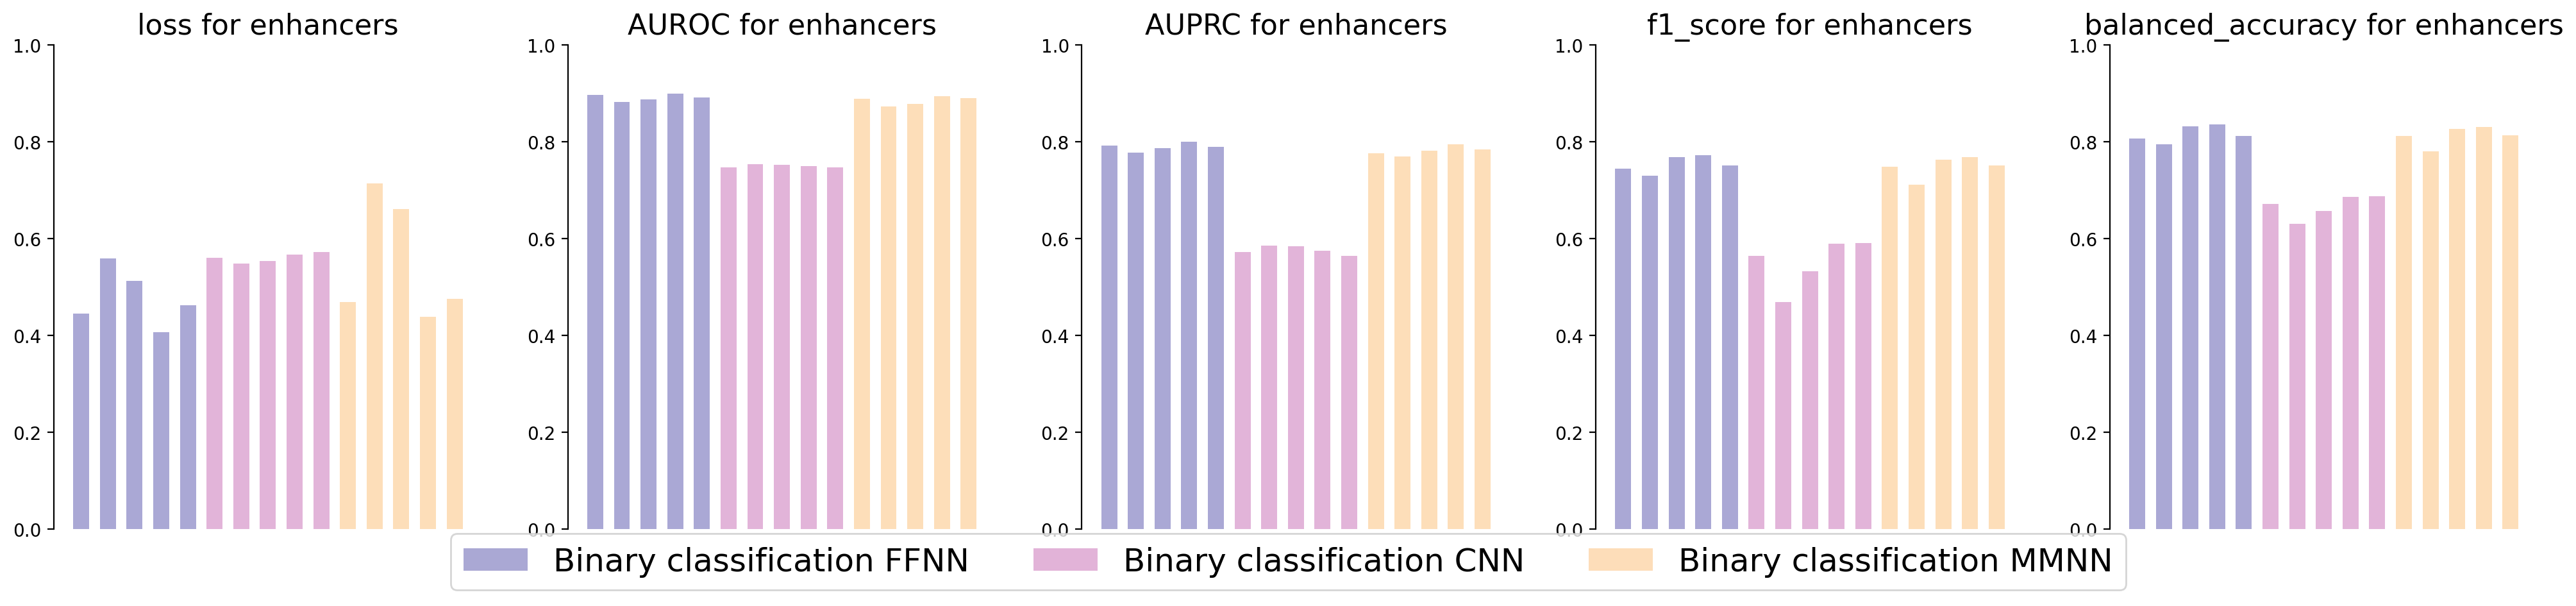

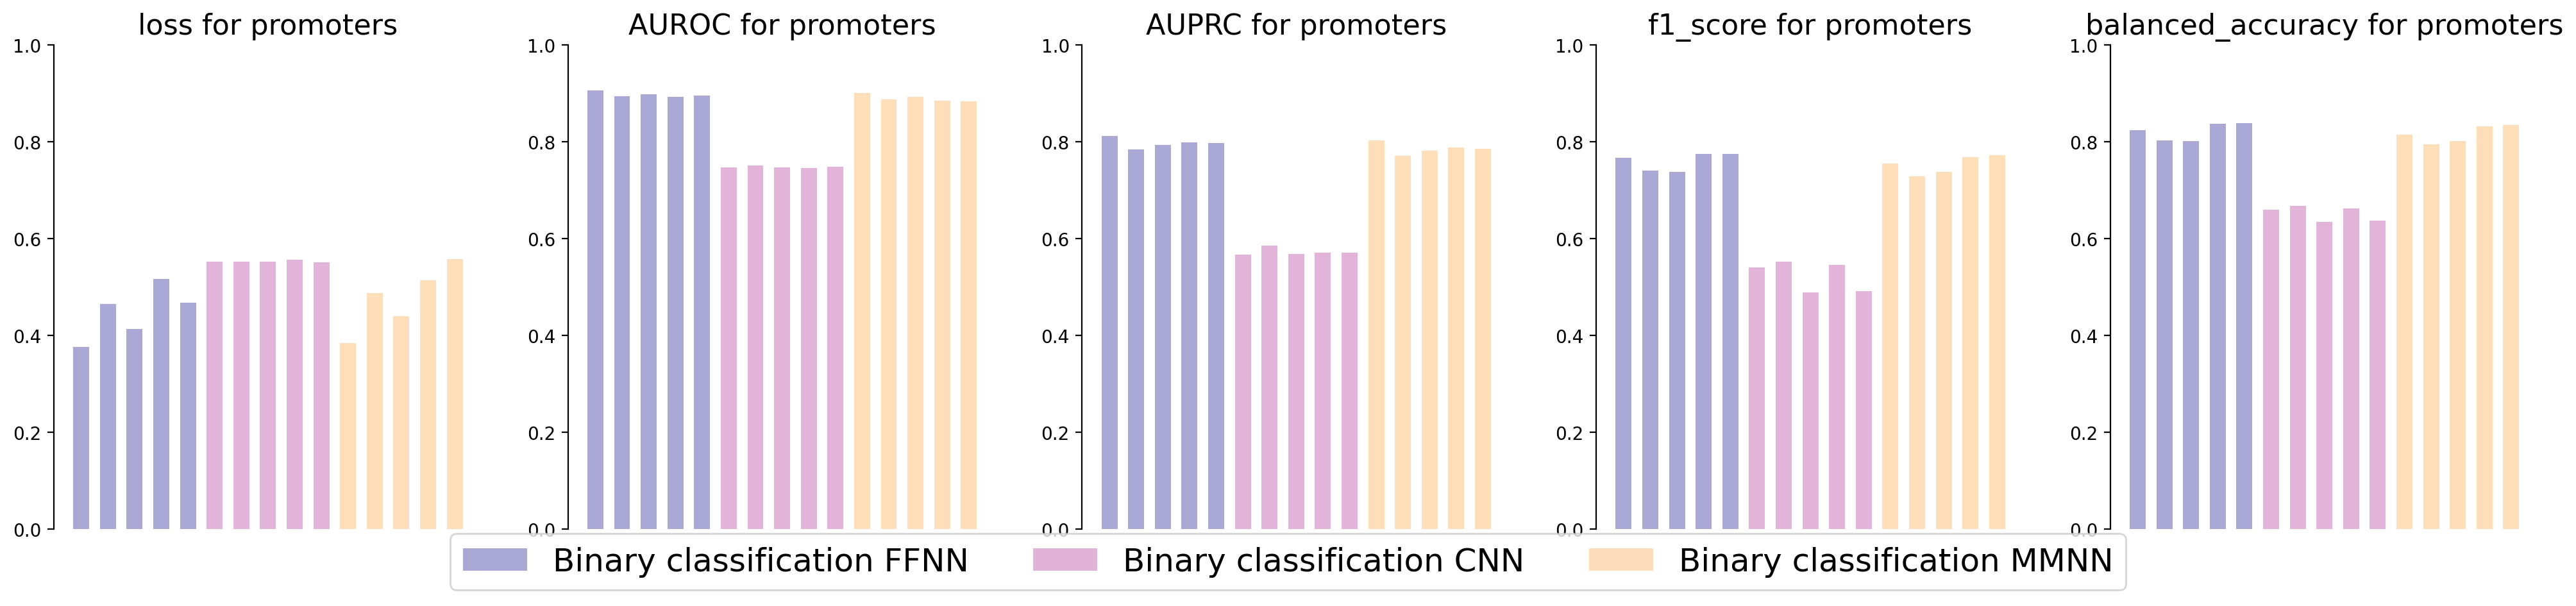

In [ ]:
from matplotlib import cm
colors = [cm.plasma(i) for i in range(0,255,100)]
metrics = ['loss','AUROC','AUPRC','f1_score','balanced_accuracy']

for task in data.keys():
    fig, axs = plt.subplots(1, len(metrics),figsize=(25, 5), dpi=200)
    for j,metric in enumerate(metrics):
        v = []
        for i, (_, model) in enumerate(data[task]['evaluation'].items()):
            for (model_name,d) in model['evaluations'].items():
                v.append(d[metric].values)
        for i, name in enumerate(model_names): 
            r = range(i*number_of_holdouts,i*number_of_holdouts+number_of_holdouts)
            axs[j].bar(r, v[i], width=0.6,
                    alpha=0.35, color=colors[i], label=name)
        axs[j].set_title(f'{metric} for {task}', fontsize=16)
        axs[j].set_xticks([])
        axs[j].set_ylim(0,1)
        for dir in ['top','bottom','right']: axs[j].spines[dir].set_visible(False)
    handles, labels = axs[j].get_legend_handles_labels()
    fig.legend(handles, labels, loc=8, ncol=3,
                   framealpha=0.8, fontsize=18)

In [ ]:
best_model_per_task = {}
for task in data.keys():
    for i, (_, model) in enumerate(data[task]['evaluation'].items()):
        for (model_name,d) in model['evaluations'].items():
            print(f"Evaluation of {model_name} for {task} (Average of {number_of_holdouts} holdouts)")
            m = pd.DataFrame(d.mean(axis=0)).T
            display(m)
            #print(model['predictions'])
            s = m[metrics[1:]].sum(axis=1)
            best_model_per_task[task].setdefault(model_name)
print(best_model_per_task)

Evaluation of Binary classification FFNN for enhancers (Average of 5 holdouts)


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.477087  0.831767  0.768272   0.742327  0.891199  0.789188  0.753377   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.816065     0.863858   0.231728  ...              0.257673   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.118297              0.295031      0.604592   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.816065      0.754337     0.62403                   5.751409   

   negative_likelyhood_ratio       DOR  
0                   0.266793  4.473874  

[1 rows x 27 columns]

Evaluation of Binary classification CNN for enhancers (Average of 5 holdouts)


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.56023  0.708565  0.539317   0.575513  0.749848  0.576088  0.549271   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.666712     0.794107   0.460683  ...              0.424487   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.224252              0.379073      0.379933   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.666712      0.553295    0.351261                   2.701499   

   negative_likelyhood_ratio       DOR  
0                   0.574457  2.012182  

[1 rows x 27 columns]

Evaluation of Binary classification MMNN for enhancers (Average of 5 holdouts)


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.551562  0.827862  0.765827   0.734568  0.885016  0.781145  0.748314   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.812522     0.859216   0.234173  ...              0.265432   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.120013              0.299324      0.598252   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.812522      0.749255    0.614555                   5.498133   

   negative_likelyhood_ratio      DOR  
0                   0.271244  4.37784  

[1 rows x 27 columns]

Evaluation of Binary classification FFNN for promoters (Average of 5 holdouts)


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.447745  0.835401  0.775786    0.74679  0.897007  0.797119  0.759099   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.820659     0.865531   0.224214  ...               0.25321   

   false_omission_rate  prevalence_threshold  threat_score  \
0              0.11453              0.292575      0.612025   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.820659      0.760193    0.632261                   5.892782   

   negative_likelyhood_ratio       DOR  
0                   0.257411  4.620349  

[1 rows x 27 columns]

Evaluation of Binary classification CNN for promoters (Average of 5 holdouts)


loss  accuracy    recall  precision     AUROC    AUPRC  f1_score  \
0  0.552671  0.709566  0.477889   0.582872  0.747882  0.57276  0.523537   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0           0.652275     0.826662   0.522111  ...              0.417128   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.241469              0.375551       0.35506   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0               0.652275      0.526937    0.341404                   2.766259   

   negative_likelyhood_ratio      DOR  
0                   0.630511  1.88018  

[1 rows x 27 columns]

Evaluation of Binary classification MMNN for promoters (Average of 5 holdouts)


loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0  0.476844  0.831096  0.767258   0.741924  0.889931  0.785603  0.752295   

   balanced_accuracy  specificity  miss_rate  ...  false_discovery_rate  \
0            0.81531     0.863361   0.232742  ...              0.258076   

   false_omission_rate  prevalence_threshold  threat_score  \
0             0.118596              0.295202      0.603222   

   fowlkes_mallows_index  informedness  markedness  positive_likelyhood_ratio  \
0                0.81531      0.753441    0.623328                   5.752884   

   negative_likelyhood_ratio       DOR  
0                   0.267776  4.454421  

[1 rows x 27 columns]

{('enhancers', 'Binary classification FFNN'): 0    3.249829
dtype: float64, ('enhancers', 'Binary classification CNN'): 0    2.541918
dtype: float64, ('enhancers', 'Binary classification MMNN'): 0    3.226997
dtype: float64, ('promoters', 'Binary classification FFNN'): 0    3.273884
dtype: float64, ('promoters', 'Binary classification CNN'): 0    2.496454
dtype: float64, ('promoters', 'Binary classification MMNN'): 0    3.243139
dtype: float64}
